<img src='https://www.utdt.edu/Images/prensa/utdt-color-alta-cmyk.jpg' width="50%">


# **Proyecto Final - Financial Analytics 2021**

Autores:

*   Corvalán Salguero, Rodrigo
*   Juárez, Lucio Ignacio
*   Juárez, Matías
*   Saguier Padilla, Juan

Profesor:

*   Roccatagliata, Pablo

En el presente colab se desarrollará todo el pipeline para el desarrollo de un modelo para operar Bitcoins, respondiendo los puntos planteados en las consignas asignadas y en línea con el workflow de López De Prado (2018).
Con el objeto de hacer comprensible el workflow, se ordenó este proyecto por secciones de tal forma se puede apreciar el índice con los bloques de código agrupados en cada sección:

1. Libraries
2. Requesting and selection Data & Data Engineering
3. Labelling & Meta-Labelling
4. Diferenciación Fraccionaria & Sample-Weights
5. Modelling:
  *   rf1: Modelo sin features con uniqueness
  *   rf2: Modelo con features y uniqueness
  *   Bagging I y II
  *   Cross Validation con y sin Embargo y Purga
  *   Optimización de Hiperparámetros (RandomSearchCV & GridSearchCV)
  *   Mejor modelo: **best_randomsearch**
6. Bet Sizing
7. Feature Importance
8. Backtesting
8. Strategy Risk
9. Portfolio Risk




<img src="https://i.imgflip.com/53v5ck.jpg" height=50%>

El objeto del RF optimizado: **best_randomsearch**

#Libraries



In [ ]:
#@title Bloque Instalaciones de Librerías
!pip install coinmetrics
!pip install fredapi 
#https://coinmetrics.readthedocs.io/_/downloads/en/latest/pdf/

# Library Imports
import coinmetrics
import pandas as pd
import numpy as np
import datetime as dt
import multiprocessing as mp
import time
import sys
import io
import requests
from random import gauss

# Graphics & others
from statsmodels.tsa.stattools import adfuller
from plotly.subplots import make_subplots
from itertools import cycle
from datetime import date, datetime, timedelta
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

# scipy, sklearn
from scipy import interp
from scipy.stats import norm
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection._split import _BaseKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_curve, classification_report, log_loss, accuracy_score, auc

# Python API for FRED
# https://mortada.net/python-api-for-fred.html
from fredapi import Fred
# Insert API key here
fred = Fred(api_key='226e29357d9d86fbf92a8384de7ddf35')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#@title Paquetes de Multiprocesamiento
# %load mpfin.py

def mpPandasObj(func,pdObj,numThreads=24,mpBatches=1,linMols=True,**kargs):
    '''
    Parallelize jobs, return a dataframe or series
    multiprocessing snippet [20.7]
    + func: function to be parallelized. Returns a DataFrame
    + pdObj[0]: Name of argument used to pass the molecule
    + pdObj[1]: List of atoms that will be grouped into molecules
    + kwds: any other argument needed by func

    Example: df1=mpPandasObj(func,('molecule',df0.index),24,**kwds)
    '''
    #if linMols:parts=linParts(len(argList[1]),numThreads*mpBatches)
    #else:parts=nestedParts(len(argList[1]),numThreads*mpBatches)
    if linMols:parts=linParts(len(pdObj[1]),numThreads*mpBatches)
    else:parts=nestedParts(len(pdObj[1]),numThreads*mpBatches)

    jobs=[]
    for i in range(1,len(parts)):
        job={pdObj[0]:pdObj[1][parts[i-1]:parts[i]],'func':func}
        job.update(kargs)
        jobs.append(job)
    if numThreads==1:out=processJobs_(jobs)
    else: out=processJobs(jobs,numThreads=numThreads)
    if isinstance(out[0],pd.DataFrame):df0=pd.DataFrame()
    elif isinstance(out[0],pd.Series):df0=pd.Series()
    else:return out
    for i in out:df0=df0.append(i)
    df0=df0.sort_index()
    return df0

def processJobs_(jobs):
    # Run jobs sequentially, for debugging
    out=[]
    for job in jobs:
        out_=expandCall(job)
        out.append(out_)
    return out


def linParts(numAtoms,numThreads):
    # partition of atoms with a single loop
    parts=np.linspace(0,numAtoms,min(numThreads,numAtoms)+1)
    parts=np.ceil(parts).astype(int)
    return parts

def nestedParts(numAtoms,numThreads,upperTriang=False):
    # partition of atoms with an inner loop
    parts,numThreads_=[0],min(numThreads,numAtoms)
    for num in range(numThreads_):
        part=1+4*(parts[-1]**2+parts[-1]+numAtoms*(numAtoms+1.)/numThreads_)
        part=(-1+part**.5)/2.
        parts.append(part)
    parts=np.round(parts).astype(int)
    if upperTriang: # the first rows are heaviest
        parts=np.cumsum(np.diff(parts)[::-1])
        parts=np.append(np.array([0]),parts)
    return parts


def reportProgress(jobNum,numJobs,time0,task):
    # Report progress as asynch jobs are completed
    msg=[float(jobNum)/numJobs, (time.time()-time0)/60.]
    msg.append(msg[1]*(1/msg[0]-1))
    timeStamp=str(dt.datetime.fromtimestamp(time.time()))
    msg=timeStamp+' '+str(round(msg[0]*100,2))+'% '+task+' done after '+ \
        str(round(msg[1],2))+' minutes. Remaining '+str(round(msg[2],2))+' minutes.'
    if jobNum<numJobs:sys.stderr.write(msg+'\r')
    else:sys.stderr.write(msg+'\n')
    return

def processJobs(jobs,task=None,numThreads=24):
    # Run in parallel.
    # jobs must contain a 'func' callback, for expandCall
    if task is None:task=jobs[0]['func'].__name__
    pool=mp.Pool(processes=numThreads)
    outputs,out,time0=pool.imap_unordered(expandCall,jobs),[],time.time()
    # Process asyn output, report progress
    for i,out_ in enumerate(outputs,1):
        out.append(out_)
        reportProgress(i,len(jobs),time0,task)
    pool.close();pool.join() # this is needed to prevent memory leaks
    return out

def expandCall(kargs):
    # Expand the arguments of a callback function, kargs['func']
    func=kargs['func']
    del kargs['func']
    out=func(**kargs)
    return out

# Exploratory Data Analysis & Data Engineering



In [ ]:
#@title API Coinmetrics: Lista de Activos y Métricas disponibles
# Objeto de referencia Coinmetrics
cm = coinmetrics.Community()

# Lista de activos disponibles:
supported_assets = cm.get_supported_assets()
print("Activos Disponibles:\n", supported_assets)

# Lista metricas disponibles para BTC.
asset = "btc"
available_data_types = cm.get_available_data_types_for_asset(asset)
print(available_data_types)

Activos Disponibles:
 ['1inch', 'aave', 'ada', 'alpha', 'ant', 'bal', 'bat', 'bch', 'bnb', 'bnb_mainnet', 'bsv', 'btc', 'btg', 'busd', 'comp', 'cro', 'crv', 'cvc', 'dai', 'dash', 'dcr', 'dgb', 'dgx', 'doge', 'dot', 'drgn', 'elf', 'eng', 'eos', 'eos_eth', 'etc', 'eth', 'ethos', 'ftt', 'fun', 'fxc', 'gas', 'gno', 'gnt', 'grin', 'gusd', 'hbtc', 'hedg', 'ht', 'husd', 'kcs', 'knc', 'lend', 'leo_eos', 'leo_eth', 'link', 'loom', 'lsk', 'ltc', 'maid', 'mana', 'mco', 'mkr', 'neo', 'nxm', 'omg', 'pax', 'paxg', 'pay', 'pivx', 'poly', 'powr', 'ppt', 'qash', 'ren', 'renbtc', 'rep', 'sai', 'snt', 'snx', 'srm', 'sushi', 'swrv', 'trx', 'trx_eth', 'tusd', 'uma', 'uni', 'usdc', 'usdk', 'usdt', 'usdt_eth', 'usdt_trx', 'vtc', 'waves', 'wbtc', 'weth', 'wnxm', 'wtc', 'xaut', 'xem', 'xlm', 'xmr', 'xrp', 'xtz', 'xvg', 'yfi', 'zec', 'zrx']
['AdrActCnt', 'BlkCnt', 'BlkSizeByte', 'BlkSizeMeanByte', 'CapMVRVCur', 'CapMrktCurUSD', 'CapRealUSD', 'DiffMean', 'FeeMeanNtv', 'FeeMeanUSD', 'FeeMedNtv', 'FeeMedUSD', 'Fee

In [ ]:
# Dataset Coinmetrics (csv, múltiples variables)

url = "https://coinmetrics.io/newdata/btc.csv"
s = requests.get(url).content
c = pd.read_csv(io.StringIO(s.decode('utf-8')))

In [ ]:
#@title Métricas asociadas a BTC en Coinmetrics
metrics=['AdrActCnt', 'TxCnt', 'TxTfrCnt', 'TxTfrValAdjNtv', 'TxTfrValMeanNtv', 
         'TxTfrValMedNtv', 'TxTfrValNtv', 'TxTfrValAdjUSD', 'TxTfrValMeanUSD', 
         'TxTfrValMedUSD', 'TxTfrValUSD', 'BlkCnt', 'BlkSizeByte', 'BlkSizeMeanByte', 
         'HashRate', 'DiffMean', 'CapMVRVCur', 'CapMrktCurUSD', 'CapRealUSD', 
         'NVTAdj', 'NVTAdj90', 'ROI1yr', 'ROI30d', 'VtyDayRet180d', 'VtyDayRet30d', 
         'VtyDayRet60d', 'FeeMeanNtv', 'FeeMedNtv', 'FeeMeanUSD', 'FeeMedUSD', 
         'IssContNtv', 'IssContPctAnn', 'IssTotNtv', 'IssContUSD', 'IssTotUSD', 
         'SplyCur', 'SplyExpFut10yrCMBI', 'SplyFF', 'PriceBTC', 'PriceUSD']

# Metric Detail

# TRANSACCIONES
# AdrActCnt           Active Addresses Count
                    # The sum count of unique addresses that were active in the network (either as a recipient or originator of a ledger change) that interval. 
                    # All parties in a ledger change action (recipients and originators) are counted. Individual addresses are not double-counted if previously active.
# TxCnt               Tx Cnt
                    # The sum count of transactions that interval. Transactions represent a bundle of intended actions to alter the ledger initiated by a user (human or machine). 
                    # Transactions are counted whether they execute or not and whether they result in the transfer of native units or not (a transaction can result in no, one, or many transfers). 
                    # Changes to the ledger mandated by the protocol (and not by a user) or post-launch new issuance issued by a founder or controlling entity are not included here.
# TxTfrCnt            Xfer Cnt
                    # The sum count of transfers that interval. Transfers represent movements of native units from one ledger entity to another distinct ledger entity. 
                    # Only transfers that are the result of a transaction and that have a positive (non-zero) value are counted.
# TxTfrValAdjNtv      Xfer'd Val, Adj (native units)
                    # The sum of native units transferred between distinct addresses that interval removing noise and certain artifacts.
# TxTfrValMeanNtv     Mean Tx Size (native units)
                    # The mean count of native units transferred per transaction (i.e., the mean size of a transaction) between distinct addresses that interval.
# TxTfrValMedNtv      Median Tx Size (native units)
                    # The median count of native units transferred per transfer (i.e., the median size of a transfer) between distinct addresses that interval.
# TxTfrValNtv         Xfer'd Val (native units)
                    # The sum of native units transferred (i.e., the aggregate size of all transfers) between distinct addresses that interval.
# TxTfrValAdjUSD      Xfer'd Val, Adj (USD)
                    # The USD value of the sum of native units transferred between distinct addresses that interval removing noise and certain artifacts.
# TxTfrValMeanUSD     Mean Tx Size (USD)
                    # The sum USD value of native units transferred divided by the count of transfers (i.e., the mean size in USD of a transfer) between distinct addresses that interval.
# TxTfrValMedUSD      Median Tx Size (USD)
                    # The median USD value transferred per transfer (i.e., the median size in USD of a transfer) between distinct addresses that interval.
# TxTfrValUSD         Xfer'd Val (USD)
                    # The sum USD value of all native units transferred (i.e., the aggregate size in USD of all transfers) between distinct addresses that interval.

# MINERÍA
# BlkCnt              Block Count
                    # The sum count of blocks created that interval that were included in the main (base) chain.
# BlkSizeByte         Sum Block Size, in bytes
                    # The sum of the size (in bytes) of all blocks created that interval.
# BlkSizeMeanByte     Mean Block Size, in bytes
                    # The mean size (in bytes) of all blocks created that day.
# HashRate            Mean Hash Rate
                    # The mean rate at which miners are solving hashes that interval. 
                    # Hash rate is the speed at which computations are being completed across all miners in the network. The unit of measurement varies depending on the protocol.
# DiffMean            Mean Difficulty
                    # The mean difficulty of finding a hash that meets the protocol-designated requirement (i.e., the difficulty of finding a new block) that interval. 
                    # The requirement is unique to each applicable cryptocurrency protocol. 
                    # Difficulty is adjusted periodically by the protocol as a function of how much hashing power is being deployed by miners.

# CAPITALIZACIÓN
# CapMVRVCur          MVRV (Market Cap / Realized Market Cap)
                    # The ratio of the sum USD value of the current supply to the sum realized USD value of the current supply.
# CapMrktCurUSD       Market Cap (USD)
                    # The sum USD value of the current supply. Also referred to as network value or market capitalization.
# CapRealUSD          Realized Market Cap (USD)
                    # The sum USD value based on the USD closing price on the day that a native unit last moved (i.e., last transacted) for all native units.
# NVTAdj              NVT
                    # The ratio of the network value (or market capitalization, current supply) divided by the adjusted transfer value. Also referred to as NVT.
# NVTAdj90            NVT 90-day Moving Avg
                    # The ratio of the network value (or market capitalization, current supply) to the 90-day moving average of the adjusted transfer value. Also referred to as NVT.

# RETORNOS
# ROI1yr              ROI, 1 Year
                    # The return on investment for the asset assuming a purchase 12 months prior.
# ROI30d              ROI, 30 Days
                    # The return on investment for the asset assuming a purchase 30 days prior.
# VtyDayRet30d        30 Day Volatility
                    # The 30D volatility, measured as the standard deviation of the natural log of daily returns over the past 30 days.
# VtyDayRet60d        60 Day Volatility
                    # The 60D volatility, measured as the standard deviation of the natural log of daily returns over the past 60 days.
# VtyDayRet180d       180 Day Volatility
                    # The 180D volatility, measured as the standard deviation of the natural log of daily returns over the past 180 days.

# FEES
# FeeMeanNtv          Mean Tx Fee (native units)
                    # The mean fee per transaction in native units that interval.
# FeeMedNtv           Median Tx Fee (native units)
                    # The median fee per transaction in native units that interval.
# FeeTotNtv           Total Fees (native units)
                    # The sum of all fees paid to miners that interval. Fees do not include new issuance.
# FeeMeanUSD          Mean Tx Fee (USD)
                    # The USD value of the mean fee per transaction that interval.
# FeeMedUSD           Median Tx Fee (USD)
                    # The USD value of the median fee per transaction that interval.

# VARIABLES DE STOCK
# IssContNtv          Coinbase Issuance (native units)
                    # The sum of new native units issued that interval. 
                    # Only those native units that are issued by a protocol-mandated continuous emission schedule are included (i.e., units manually released from escrow or otherwise disbursed are not included).
                    # USADA EN LA CONSTRUCCIÓN DE Stock-To-Flow
# IssTotNtv           Total Issuance (native units)
                    # The sum of all new native units issued that interval.
# IssContPctAnn       Annual Inflation Rate
                    # The percentage of new native units (continuous) issued over that interval, extrapolated to one year (i.e., multiplied by 365), and divided by the current supply at the end of that interval. 
                    # Also referred to as the annual inflation rate.
# IssContUSD          Coinbase Issuance (USD)
                    # The sum USD value of new native units issued that interval. 
                    # Only those native units that are issued by a protocol-mandated continuous emission schedule are included (i.e., units manually released from escrow or otherwise disbursed are not included).
# IssTotUSD           Total Issuance (USD)
                    # The sum USD value of all new native units issued that interval.
# SplyCur             Current Supply (native units)
                    # The sum of all native units ever created and visible on the ledger (i.e., issued) at the end of that interval. 
                    # For account-based protocols, only accounts with positive balances are counted.
                    # USADA EN LA CONSTRUCCIÓN DE Stock-To-Flow
# SplyExpFut10yrCMBI  10 Year Expected Supply, Adj (native units)
                    # The sum of all native units counting current supply and including all those expected to be issued over the next 10 years from that interval if the current known continuous issuance schedule is followed. 
                    # Future expected hard-forks that will change the continuous issuance are not considered until the day they are activated/enforced. 
                    # This metric is a variant of SplyExpFut10yr that accounts for the additional heuristics used in the Coin Metrics Bletchey Index (CMBI).
# SplyFF              Free Float Supply (native units)
                    # Free float supply refers to the number of native units of a crypto asset that are readily available to trade in open markets (i.e. not restricted) at the end of the time interval. 
                    # It includes all native units visible on the ledger minus company, foundation and founding team native units; investor units that have been formally restricted (through legal or smart contracts); burnt units that are still visible on chain; or provably lost units (if >0.25% of supply).

# PRECIOS
# PriceBTC            BTC Denominated Price
                    # The fixed closing price of the asset as of 00:00 UTC the following day (i.e., midnight UTC of the current day) for end-of-day data or the closest prior hour (nearest to that block) for block-by-block data, denominated in BTC.
# PriceUSD            USD Denominated Closing Price
                    # The fixed closing price of the asset as of 00:00 UTC the following day (i.e., midnight UTC of the current day) denominated in USD. 
                    # This price is generated by Coin Metrics' fixing/reference rate service. Real-time PriceUSD is the fixed closing price of the asset as of the timestamp set by the block's miner.
                    # USADA COMO VARIABLE PRINCIPAL

In [ ]:
#@title Métricas en Dataframe
asset = "btc"
for i, metric in enumerate(metrics):
  begin_timestamp_coinmetrics = "2010-07-01"
  begin_timestamp = begin_timestamp_coinmetrics #new
  end_timestamp = dt.datetime.now() - dt.timedelta(days=-1) # The `datetime` type is also accepted
  end_timestamp = end_timestamp.strftime('%Y-%m-%d')
  asset_data = cm.get_asset_data_for_time_range(asset, metric, begin_timestamp, end_timestamp)
  if i == 0:
      df_cor = coinmetrics.cm_to_pandas(asset_data)
      df_cor.index.name = 'date'
  else:
    df_cor[metric] = coinmetrics.cm_to_pandas(asset_data)
 

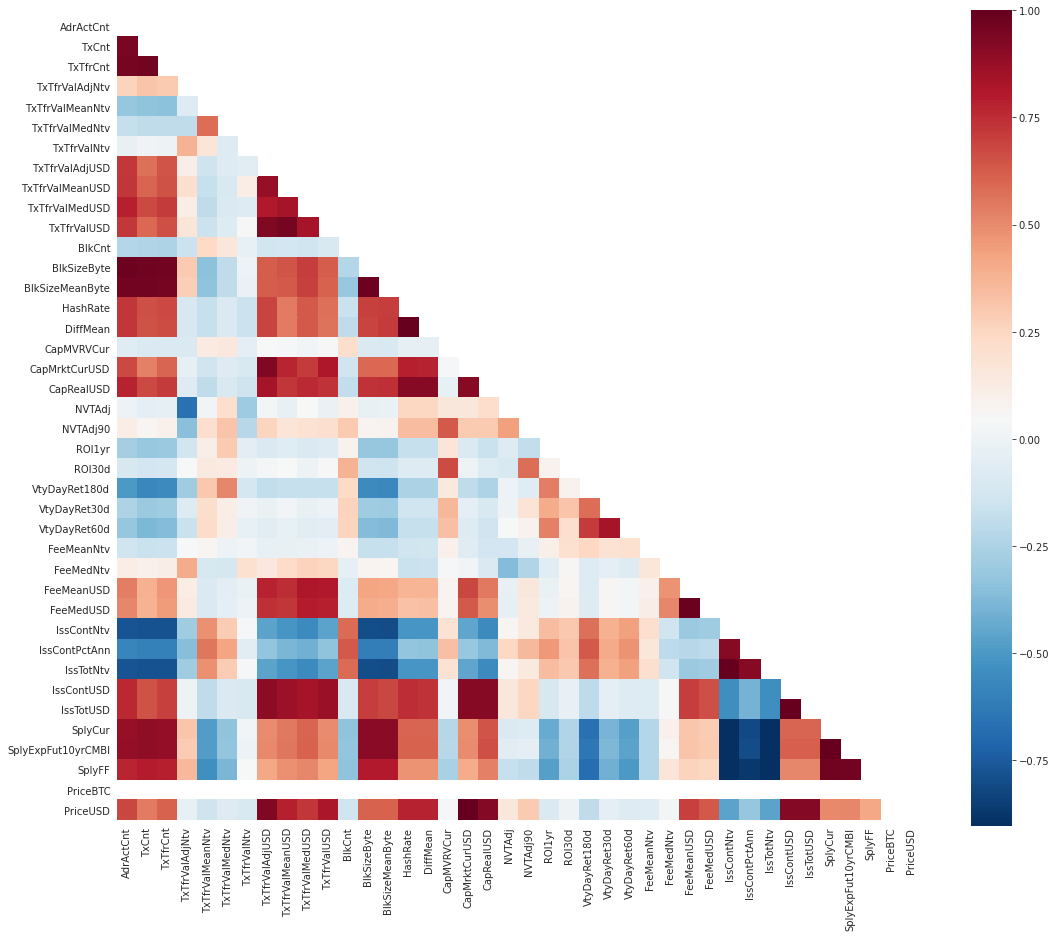

In [ ]:
#@title Matriz de correlacion entre los predictores

corr = df_cor.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(18, 15))
    ax = sns.heatmap(corr, mask=mask, cmap="RdBu_r", square=True)


Quitamos las variables con información duplicada, expresadas en USD, para evitar correlaciones con la variable PriceUSD:

*   'TxTfrValAdjUSD'
*   'TxTfrValMeanUSD'
*   'TxTfrValMedUSD'
*   'TxTfrValUSD'
*   'FeeMeanUSD'
*   'FeeMedUSD'
*   'IssContUSD'
*    'IssTotUSD'

Quitamos las variables asociadas a Stock To Flow (asociada a IssContNtv y SplyCur):
* 'IssContNtv'
* 'IssContPctAnn'
* 'IssTotNtv'
* 'SplyCur'
* 'SplyExpFut10yrCMBI'
* 'SplyFF'

Quitamos la variable 'PriceBTC' porque es constante.

Quitamos la variable 'DiffMean' porque es colineal con 'HashRate'.

Quitamos la variable 'BlkSizeMeanByte' porque es colineal con 'BlkSizeByte'.

Quitamos la variable 'CapMrktCurUSD' porque es colineal con 'PriceUSD'.

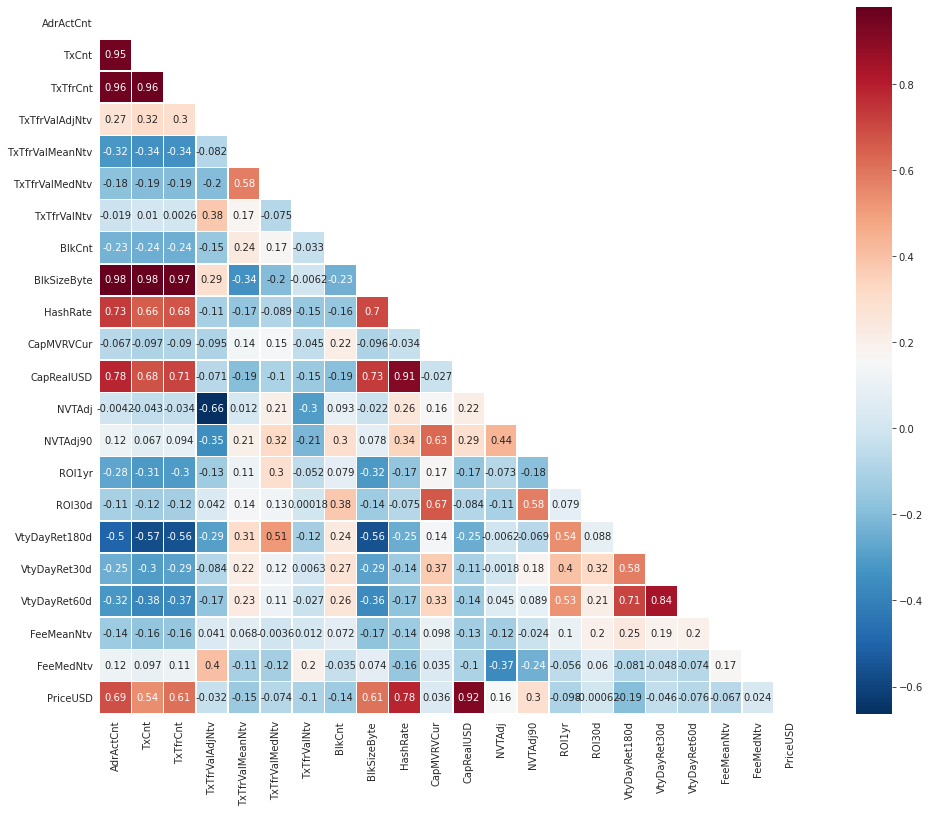

In [ ]:
# Valores más ligados a la variable 'PriceUSD': 
corr_2 = df_cor[['AdrActCnt', 'TxCnt', 'TxTfrCnt', 'TxTfrValAdjNtv', 'TxTfrValMeanNtv', 
                 'TxTfrValMedNtv', 'TxTfrValNtv', 'BlkCnt', 'BlkSizeByte', 'HashRate', 
                 'CapMVRVCur', 'CapRealUSD', 'NVTAdj', 'NVTAdj90', 'ROI1yr', 'ROI30d', 
                 'VtyDayRet180d', 'VtyDayRet30d', 'VtyDayRet60d', 'FeeMeanNtv', 'FeeMedNtv', 'PriceUSD']]

corr_2 = corr_2.corr()
mask = np.zeros_like(corr_2)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(18, 13))
    ax = sns.heatmap(corr_2, mask=mask, cmap="RdBu_r", square=True, annot= True, linewidths=.5)

In [ ]:
# Variables potenciales: 'AdrActCnt', 'HashRate'
df_cor.index = pd.to_datetime(df_cor.index).tz_localize(None) # Quito el formato UTC
print(df_cor)

            AdrActCnt     TxCnt  TxTfrCnt  ...        SplyFF  PriceBTC      PriceUSD
date                                       ...                                      
2010-07-01      403.0      76.0      91.0  ...  3.188850e+06       1.0           NaN
2010-07-02      398.0      80.0      95.0  ...  3.197200e+06       1.0           NaN
2010-07-03      326.0      66.0      79.0  ...  3.207800e+06       1.0           NaN
2010-07-04      431.0      58.0      64.0  ...  3.216100e+06       1.0           NaN
2010-07-05      380.0      71.0      77.0  ...  3.225050e+06       1.0           NaN
...               ...       ...       ...  ...           ...       ...           ...
2021-03-26  1085835.0  293636.0  928803.0  ...  1.457538e+07       1.0  54817.857112
2021-03-27  1149403.0  286113.0  866821.0  ...  1.457518e+07       1.0  56019.837306
2021-03-28  1063472.0  244181.0  733563.0  ...  1.457601e+07       1.0  55713.038140
2021-03-29  1115525.0  307500.0  935905.0  ...  1.457612e+07     

In [ ]:
#@title Serie de Precios de Bitcoin (BTC) y Exploratory Data Analysis (EDA)
# %% Serie precios btc cruda
# Tomamos `PriceUSD` data de BTC desde 2010-07-01 hasta hoy.
asset = "btc"
metric = "PriceUSD"

# Fechas: Julio de 2010 es desde donde tiene datos Coinmetrics
begin_timestamp_coinmetrics = "2010-07-01"
begin_timestamp = begin_timestamp_coinmetrics #new
end_timestamp = dt.datetime.now() - dt.timedelta(days=-1)
end_timestamp = end_timestamp.strftime('%Y-%m-%d')

# Data:
asset_data = cm.get_asset_data_for_time_range(asset, metric, begin_timestamp, end_timestamp)
df = coinmetrics.cm_to_pandas(asset_data)
df.index.name = 'date'
fig = px.line(df, x=df.index ,y="PriceUSD")
fig.show()

# Print:
df.index = pd.to_datetime(df.index).tz_localize(None) # Quito el formato UTC
print(df)


                PriceUSD
date                    
2010-07-18      0.085840
2010-07-19      0.080800
2010-07-20      0.074736
2010-07-21      0.079193
2010-07-22      0.058470
...                  ...
2021-03-27  56019.837306
2021-03-28  55713.038140
2021-03-29  57571.233348
2021-03-30  58684.548392
2021-03-31  58792.194828

[3910 rows x 1 columns]


Para el EDA y definir cuánto de la serie usar calculamos volatilidad en el tiempo. Observamos cuándo empieza a ser parecida a hoy.

In [ ]:
# Calculamos el desvío (volatilidad) histórica de Bitcoin
#Volat_historica = df['PriceUSD'].std()
#df['Volat_ult30d'] = df['PriceUSD'].rolling(window=30).std()
#print(df['Volat_ult30d'])
#print("La volatilidad histórica de BTC es: ", Volat_historica)
#volat = px.line(df, x=df.index ,y="Volat_ult30d")
#volat.show()

# FORMA que replica el cálculo de COINMETRICS (en Coinmetrics no está anualizada, es decir, no tiene el * 252 ** 0.5)

# Calculamos los retornos logarítmicos de Bitcoin
retornos_log = (np.log(df.PriceUSD / df.PriceUSD.shift(-1)))      
# Calculamos el desvío estándar diario de los retornos 
std_diario = np.std(retornos_log)
std_diario_anual = std_diario * 252 ** 0.5
print("La volatilidad diaria anualizada histórica de BTC es: ", std_diario_anual)

# Calculamos el desvío estándar diario de los retornos en una ventana móvil
std_ult30d = pd.Series(retornos_log.rolling(window=30).std() * 252 ** 0.5, name='std_ult30d')
print("La volatilidad diaria en media móvil 30d anualizada histórica de BTC es: ", std_ult30d.mean())
print("El mínimo de la serie fue: ", std_ult30d.min())
print("El máximo de la serie fue: ", std_ult30d.max())

# Realizamos un primer gráfico para entender la dinámica histórica
std_ult30d_graph = px.line(std_ult30d, x=std_ult30d.index ,y="std_ult30d")
std_ult30d_graph.show()

# Realizamos un segundo gráfico para comprender el TREND actual
std_ult30d["2020-11-01":"2021-03-27"]

std_ult30d_graph_reciente = px.line(std_ult30d["2020-11-01":"2021-03-27"], x=std_ult30d["2020-11-01":"2021-03-27"].index ,y="std_ult30d")
std_ult30d_graph_reciente.show()



La volatilidad diaria anualizada histórica de BTC es:  0.848143745354094
La volatilidad diaria en media móvil 30d anualizada histórica de BTC es:  0.6967844342551559
El mínimo de la serie fue:  0.11874984185403224
El máximo de la serie fue:  3.0434941295710427


In [ ]:
#@title Agregamos las variables 'AdrActCnt' y 'HashRate'
df = df.join(df_cor[['AdrActCnt', 'HashRate']], on="date", how="left")
df= df.dropna()
df

,PriceUSD,AdrActCnt,HashRate
date,,,
2010-07-18,0.085840,860.0,1.552225e-03
2010-07-19,0.080800,929.0,1.570274e-03
2010-07-20,0.074736,936.0,1.633446e-03
2010-07-21,0.079193,784.0,1.868085e-03
2010-07-22,0.058470,594.0,1.588324e-03
...,...,...,...
2021-03-26,54817.857112,1085835.0,1.478242e+08
2021-03-27,56019.837306,1149403.0,1.728239e+08
2021-03-28,55713.038140,1063472.0,1.728239e+08


In [ ]:
#@title Feature Engineering: Variable Stock to Flow (S2F)
# Serie Units Issued BTC 
# The sum of new native units issued that day. Only those native units that are issued by a protocol-mandated
# continuous emission schedule are included

#usamos un begin timestamp de 1 año antes porue con la media movil vamos a perderlo, y asi coincide con la serie de precio de BTC
#begin_timestamp = "2016-07-01" # The `datetime` type is also accepted
end_timestamp = dt.datetime.now() #- dt.timedelta(days=-1) # The `datetime` type is also accepted
end_timestamp = end_timestamp.strftime('%Y-%m-%d')
asset_data_IssContNtv = cm.get_units_issued(asset, 
                                            begin_timestamp, 
                                            end_timestamp)
df_IssContNtv = coinmetrics.cm_to_pandas(asset_data_IssContNtv)
# print("pandas data frame:\n", df_s2f)
df_IssContNtv.index.name = 'date'
fig = px.line(df_IssContNtv, 
              x = df_IssContNtv.index, 
              y = "IssContNtv")
fig.show()

df_IssContNtv.index = pd.to_datetime(df_IssContNtv.index).tz_localize(None) # Quito el formato UTC
print(df_IssContNtv)

# Serie Supply BTC 
# The sum of all native units ever created and visible on the ledger 
# (i.e., issued) as of that day. For account based protocols, only 
# accounts with positive balances are counted
asset_data_SplyCur = cm.get_cur_sply(asset, begin_timestamp, end_timestamp)
df_SplyCur = coinmetrics.cm_to_pandas(asset_data_SplyCur)

# print("pandas data frame:\n", df_s2f)
df_SplyCur.index.name = 'date'
fig = px.line(df_SplyCur, x=df_SplyCur.index ,y="SplyCur")
fig.show()

df_SplyCur.index = pd.to_datetime(df_IssContNtv.index).tz_localize(None) # Quito el formato UTC
print(df_SplyCur)



            IssContNtv
date                  
2010-07-01    10550.00
2010-07-02     8350.00
2010-07-03    10600.00
2010-07-04     8300.00
2010-07-05     8950.00
...                ...
2021-03-27      993.75
2021-03-28      993.75
2021-03-29      943.75
2021-03-30      912.50
2021-03-31      981.25

[3927 rows x 1 columns]


                 SplyCur
date                    
2010-07-01  3.188850e+06
2010-07-02  3.197200e+06
2010-07-03  3.207800e+06
2010-07-04  3.216100e+06
2010-07-05  3.225050e+06
...                  ...
2021-03-27  1.866614e+07
2021-03-28  1.866713e+07
2021-03-29  1.866808e+07
2021-03-30  1.866899e+07
2021-03-31  1.866997e+07

[3927 rows x 1 columns]


In [ ]:
dfs2f = df_IssContNtv.join(df_SplyCur, on='date', how='left')

In [ ]:
dfs2f

,IssContNtv,SplyCur
date,,
2010-07-01,10550.00,3.188850e+06
2010-07-02,8350.00,3.197200e+06
2010-07-03,10600.00,3.207800e+06
2010-07-04,8300.00,3.216100e+06
2010-07-05,8950.00,3.225050e+06
...,...,...
2021-03-27,993.75,1.866614e+07
2021-03-28,993.75,1.866713e+07
2021-03-29,943.75,1.866808e+07


In [ ]:
window_s2f_1 = 365
dfs2f['RollAvgIssContNtv_365'] = dfs2f.rolling(window_s2f_1, min_periods=None, center=False, win_type=None, on=None, axis=0, closed=None)['IssContNtv'].sum()
window_s2f_2 = 30
dfs2f['RollAvgIssContNtv_30'] = dfs2f.rolling(window_s2f_2, min_periods=None, center=False, win_type=None, on=None, axis=0, closed=None)['IssContNtv'].sum()
window_s2f_3 = 10
dfs2f['RollAvgIssContNtv_10'] = dfs2f.rolling(window_s2f_3, min_periods=None, center=False, win_type=None, on=None, axis=0, closed=None)['IssContNtv'].sum()

dfs2f['S2F_365'] = dfs2f['SplyCur'] / dfs2f['RollAvgIssContNtv_365']
dfs2f['S2F_30'] = dfs2f['SplyCur'] / dfs2f['RollAvgIssContNtv_30']
dfs2f['S2F_10'] = dfs2f['SplyCur'] / dfs2f['RollAvgIssContNtv_10']
dfs2f

,IssContNtv,SplyCur,RollAvgIssContNtv_365,RollAvgIssContNtv_30,RollAvgIssContNtv_10,S2F_365,S2F_30,S2F_10
date,,,,,,,,
2010-07-01,10550.00,3.188850e+06,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-02,8350.00,3.197200e+06,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-03,10600.00,3.207800e+06,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-04,8300.00,3.216100e+06,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-05,8950.00,3.225050e+06,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2021-03-27,993.75,1.866614e+07,375718.75,27556.25,9518.75,49.681147,677.383121,1960.986330
2021-03-28,993.75,1.866713e+07,375025.00,27681.25,9562.50,49.775701,674.360167,1952.118419
2021-03-29,943.75,1.866808e+07,374081.25,27643.75,9581.25,49.903801,675.309107,1948.396726


In [ ]:
px.line(dfs2f, x=dfs2f.index ,y="S2F_365")

Unimos la serie de BTC y la de los features


In [ ]:
# Nos quedamos con la media movil de 365 del Stock to Flow
pd.DataFrame(dfs2f['S2F_365'])
df = df.join(pd.DataFrame(dfs2f['S2F_365']), on="date", lsuffix="PriceBTC", how="left")
df

,PriceUSD,AdrActCnt,HashRate,S2F_365
date,,,,
2010-07-18,0.085840,860.0,1.552225e-03,NaN
2010-07-19,0.080800,929.0,1.570274e-03,NaN
2010-07-20,0.074736,936.0,1.633446e-03,NaN
2010-07-21,0.079193,784.0,1.868085e-03,NaN
2010-07-22,0.058470,594.0,1.588324e-03,NaN
...,...,...,...,...
2021-03-26,54817.857112,1085835.0,1.478242e+08,49.554030
2021-03-27,56019.837306,1149403.0,1.728239e+08,49.681147
2021-03-28,55713.038140,1063472.0,1.728239e+08,49.775701


In [ ]:
#@title Feature Engineering: Eras de los Halvings (Cambios estructurales)
# Creamos variables dummies sobre los halvings para identificar
# (si hay) cambios estructurales ocurridos los halvings, dividiendo
# la serie de BTC en etapas según halvings:

BTC_launch = datetime.strptime("2009-01-03" , '%Y-%m-%d')
First_halving = datetime.strptime("2012-11-28" , '%Y-%m-%d')
Second_halving = datetime.strptime("2016-07-09" , '%Y-%m-%d')
Third_halving = datetime.strptime("2020-05-18" , '%Y-%m-%d')
Fourth_halving = datetime.strptime("2024-05-18" , '%Y-%m-%d') # ESTIMATED

halvings_df = pd.DataFrame({'BTC Launch': [0],
                            'First Halving': [0],
                            'Second Halving': [0],
                            'Third Halving': [0],
                            'Around Halving': [0]},
                           index = pd.date_range(start = '2009-07-01', end = date.today().strftime('%Y-%m-%d'), freq = 'D'))

# Populamos la variable Dummy "BTC Launch"
for i in halvings_df.index:
    if i > BTC_launch and i < First_halving:
        halvings_df['BTC Launch'][i] = 1
else:
    halvings_df['BTC Launch'][i] = 0
halvings_df


# Populamos la variable Dummy "First Halving"
for i in halvings_df.index:
    if i >= First_halving and i < Second_halving:
        halvings_df['First Halving'][i] = 1
else:
    halvings_df['First Halving'][i] = 0
halvings_df


# Populamos la variable Dummy "Second Halving"
for i in halvings_df.index:
    if i >= Second_halving and i < Third_halving:
        halvings_df['Second Halving'][i] = 1
else:
    halvings_df['Second Halving'][i] = 0
halvings_df


# Populamos la variable Dummy "Third Halving"
for i in halvings_df.index:
    if i >= Third_halving and i < Fourth_halving:
        halvings_df['Third Halving'][i] = 1
else:
    halvings_df['Third Halving'][i] = 0
halvings_df

# Populamos la variable Dummy "Around Halving"
ventana_around = 365

for i in halvings_df.index:
    if i >= First_halving + timedelta(days = -ventana_around) and i <= First_halving + timedelta(days = ventana_around):
        halvings_df['Around Halving'][i] = 1
    if i >= Second_halving + timedelta(days = -ventana_around) and i <= Second_halving + timedelta(days = ventana_around):
        halvings_df['Around Halving'][i] = 1
    if i >= Third_halving + timedelta(days = -ventana_around) and i <= Third_halving + timedelta(days = ventana_around):
        halvings_df['Around Halving'][i] = 1
else:
    halvings_df['Around Halving'][i] = 0

halvings_df

,BTC Launch,First Halving,Second Halving,Third Halving,Around Halving
2009-07-01,1,0,0,0,0
2009-07-02,1,0,0,0,0
2009-07-03,1,0,0,0,0
2009-07-04,1,0,0,0,0
2009-07-05,1,0,0,0,0
...,...,...,...,...,...
2021-03-28,0,0,0,1,1
2021-03-29,0,0,0,1,1
2021-03-30,0,0,0,1,1
2021-03-31,0,0,0,1,1


In [ ]:
#@title Agregamos data de la Federal Reserve Economic Data (FRED), yield curve.
#@markdown En este bloque agregamos data referente a oferta de dinero y tasas
#@markdown a nivel macro-monetario, susodicha liquidez reflejada en la evolución
#@markdown de la tasa de interés, nos provee de alguna información relevante para el modelo.

# 10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity (T10Y2Y)
# fred.get_series('T10Y2Y')

df_fred = {}
df_fred['T10Y2Y'] = fred.get_series('T10Y2Y')
df_fred = pd.DataFrame(df_fred)

df_fred_filtered = df_fred.loc['2010-07-01':end_timestamp] # La fecha lockeada es la del inicio de la serie de BTC
# df_fred_filtered.plot()

px.line(df_fred_filtered, x=df_fred_filtered.index ,y="T10Y2Y").show()

lista = fred.search('treasury').T
lista = lista[lista.columns[(lista.loc['frequency_short']=='D') & (lista.loc['units']=='Percent')]]

#10-Year Treasury Constant Maturity Rate
lista[lista.columns[(lista.loc['title']=='10-Year Treasury Constant Maturity Rate')]]
df_fred['DGS10'] = fred.get_series('DGS10')

# 2-Year Treasury Constant Maturity Rate
lista[lista.columns[(lista.loc['title']=='2-Year Treasury Constant Maturity Rate')]]
# id: DGS2
df_fred['DGS2'] = fred.get_series('DGS2')

df_fred = pd.DataFrame(df_fred).fillna(method='ffill')

In [ ]:
df_fred_filtered = df_fred.loc['2010-07-01':end_timestamp] # La fecha lockeada es la del inicio de la serie de BTC

px.line(df_fred_filtered, x=df_fred_filtered.index ,y="DGS10").show()
px.line(df_fred_filtered, x=df_fred_filtered.index ,y="DGS2").show()

#Labelling & Meta-Labelling

## Bloques de Funciones y Snippets necesarios:

In [ ]:
#@title Labelling (snippets y funciones de López De Prado)

def getDailyVol(close, span0=100):
    '''
    Computes the daily volatility of price returns.
    It takes a closing price series, applies a diff sample to sample
    (assumes each sample is the closing price), computes an EWM with 
    `span0` samples and then the standard deviation of it.
    
    See Advances in Financial Analytics, snippet 3.1
    
    @param[in] close A series of prices where each value is the closing price of an asset.
               The index of the series must be a valid datetime type.
    @param[in] span0 The sample size of the EWM.
    @return A pandas series of daily return volatility.
    '''
    df0 = close.index.searchsorted(close.index-pd.Timedelta(days=1))
#probamos una modificacion dados los comentarios en Slack:
    #df0=closeIdx.searchsorted(pd.to_datetime([t1.index[0],t1.max()]))
    #iloc=closeIdx.searchsorted(np.array([t1.index[0],t1.max()]))


    df0 = df0[df0 > 0]
    df0 = pd.Series(close.index[df0-1], index=close.index[close.shape[0]-df0.shape[0]:])
    df0 = close.loc[df0.index] / close.loc[df0.values].values-1 # Daily returns
    df0 = df0.ewm(span=span0).std()
    return df0

def getVerticalBarrier(tEvents, close, numDays=0):
    """
    Adding a Vertical Barrier
    For each index in t_events, it finds the timestamp of the next price bar at or immediately after
    a number of days num_days. This vertical barrier can be passed as an optional argument t1 in get_events.
    This function creates a series that has all the timestamps of when the vertical barrier would be reached.
    
    Advances in Financial Machine Learning, Snippet 3.4 page 49.
    
    @param tEvents A pd.DateTimeIndex of events.
    @param close A pd.Series of close prices.
    @param numDays The number of days to add for vertical barrier.
    @return A pd.Series of Timestamps of vertical barriers
    """
    verticalBarrier = close.index.searchsorted(tEvents + pd.Timedelta(days=numDays))
    verticalBarrier = verticalBarrier[verticalBarrier < close.shape[0]]
    return pd.Series(close.index[verticalBarrier], index = tEvents[:verticalBarrier.shape[0]]) # NaNs at the end

def applyPtSlOnT1(close, events, ptSl, molecule):
    '''
    Apply stop loss/profit taking, if it takes place before t1 (vertical barrier)
    (end of event).
    
    Advances in Financial Machine Learning, snippet 3.2 page 45.
    @param close
    @param events
    @param ptSl
    @param molecule
    @return
    '''
    events_ = events.loc[molecule]
    out = events_[['t1']].copy(deep=True)
    
    if ptSl[0] > 0:
        pt = ptSl[0] * events_['trgt']
    else:
        pt = pd.Series(index=events.index) # NaNs
    
    if ptSl[1] > 0:
        sl = -ptSl[1] * events_['trgt']
    else:
        sl=pd.Series(index=events.index) # NaNs
    
    for loc, t1 in events_['t1'].fillna(close.index[-1]).iteritems():
        df0 = close[loc:t1] # path prices
        df0 = (df0 / close[loc] - 1) * events_.at[loc,'side'] # path returns
        out.loc[loc,'sl'] = df0[df0<sl[loc]].index.min() # earliest stop loss
        out.loc[loc,'pt'] = df0[df0>pt[loc]].index.min() # earliest profit taking
    return out

def getEvents(close, tEvents, ptSl, trgt, minRet, numThreads, t1=False, side=None):
    #1) get target
    trgt=trgt.loc[tEvents]
    trgt=trgt[trgt>minRet] # minRet
    #2) get t1 (max holding period)
    if t1 is False:
        t1 = pd.Series(pd.NaT, index=tEvents)
    #3) form events object, apply stop loss on t1
    if side is None:
        side_, ptSl_ = pd.Series(1.,index=trgt.index), [ptSl[0],ptSl[0]]
    else:
        side_, ptSl_= side.loc[trgt.index],ptSl[:2]
    events = (pd.concat({'t1':t1,'trgt':trgt,'side':side_}, axis=1) .dropna(subset=['trgt']))
    df0=mpPandasObj(func=applyPtSlOnT1,pdObj=('molecule',events.index),
                    numThreads=numThreads,close=close,events=events,
                    ptSl=ptSl_)
    events['t1'] = df0.dropna(how='all').min(axis=1) # pd.min ignores nan
    if side is None:events=events.drop('side',axis=1)
    return events

def getBinsOld(events,close):
    # Snippet 3.5
    #1) prices aligned with events
    events_=events.dropna(subset=['t1'])
    px=events_.index.union(events_['t1'].values).drop_duplicates()
    px=close.reindex(px,method='bfill')
    #2) create out object
    out=pd.DataFrame(index=events_.index)
    out['ret']=px.loc[events_['t1'].values].values/px.loc[events_.index]-1
    out['bin']=np.sign(out['ret'])
    # Where out index and t1 (vertical barrier) intersect label 0
    # See page 49, it is a suggested exercise.
    try:
        locs = out.query('index in @t1').index
        out.loc[locs, 'bin'] = 0
    except:
        pass
    return out


def getBins(events, close):
    '''
    Compute event's outcome (including side information, if provided).
    
    Snippet 3.7
    
    Case 1: ('side' not in events): bin in (-1,1) <-label by price action
    Case 2: ('side' in events): bin in (0,1) <-label by pnl (meta-labeling)
    
    @param events It's a dataframe whose 
      - index is event's starttime
      - Column t1 is event's endtime
      - Column trgt is event's target
      - Column side (optional) implies the algo's position side.
    @param close It's a close price series.
    '''
    #1) prices aligned with events
    events_=events.dropna(subset=['t1'])
    px=events_.index.union(events_['t1'].values).drop_duplicates()
    px=close.reindex(px,method='bfill')
    #2) create out object
    out=pd.DataFrame(index=events_.index)
    out['ret']=px.loc[events_['t1'].values].values/px.loc[events_.index]-1
    if 'side' in events_:
        out['ret']*=events_['side'] # meta-labeling
    out['bin']=np.sign(out['ret'])
    if 'side' in events_:
        out.loc[out['ret']<=0,'bin']=0 # meta-labeling
    return out


def dropLabels(events, minPct=.05):
    '''
    Takes a dataframe of events and removes those labels that fall
    below minPct (minimum percentil).
    
    Snippet 3.8
    
    @param events An events dataframe, such as the output of getBins()
    @param minPct The minimum percentil of rare labels to have.
    @return The input @p events dataframe but filtered.
    '''
    # apply weights, drop labels with insufficient examples
    while True:
        df0=events['bin'].value_counts(normalize=True)
        if df0.min()>minPct or df0.shape[0]<3:break
        print('dropped label: ', df0.argmin(),df0.min())
        events=events[events['bin']!=df0.argmin()]
    return events

In [ ]:
#@title Events (funciones de Eventos / Cruce de Medias)

def cusumFilterEvents(close, threshold):
    '''
    Symmetric CUSUM Filter.
    It is a quality-control method, designed to detect a shift in
    the mean value of the measured quantity away from a target value.
    The value of each filter is:
      S^{+}_t = max{0, S^{+}_{t-1} + y_t - E_{t-1}[y_t]}, S^{+}_0 = 0
      S^{-}_t = mix{0, S^{-}_{t-1} + y_t - E_{t-1}[y_t]}, S^{-}_0 = 0
      S_t = max{S^{+}_t, -S^{-}_t}

    See Advances in Financial Analytics, snippet 2.4, page 39.


    @param close A price series.
    @param threshold A positive threshold to flag a positive or negative
           event when either S^{+}_t or S^{-}_t is greater than it.
    @return A subset of the @p close index series where the events of
            filter are triggered.
    '''
    tEvents = []
    sPos = 0
    sNeg = 0
    
    diff = close.diff()
    for i in diff.index[1:]:
        sPos, sNeg = max(0, sPos+diff.loc[i]), min(0, sNeg+diff.loc[i])
        if sNeg < -threshold:
            sNeg = 0
            tEvents.append(i)
        elif sPos > threshold:
            sPos = 0
            tEvents.append(i)
    return pd.to_datetime(tEvents)


def getEwmDf(close, fast_window_num_days=3, slow_window_num_days=7):
    # GENERA UN DATAFRAME CON LA SERIE Y DOS MEDIAS MÓVILES DE ELLA.
    '''
    Generates a close prices dataframe with three columns, where:
    - Column "close" is the `close` price.
    - Column "fast" is the `fast` EWM with @p fast_window_num_days days window size.
    - Column "slow" is the `slow` EWM with @p slow_window_num_days days window size.
    
    @param close A pandas series of close daily prices.
    @param fast_window_num_days A positive integer indicating the fast window size in days.
    @param slow_window_num_days A positive integer indicating the slow window size in days,
           which is greater than @p fast_window_num_days.
    @return A dataframe as described above.
    '''
    close_df = (pd.DataFrame()
                .assign(close=close)
                .assign(fast=close.ewm(fast_window_num_days).mean())
                .assign(slow=close.ewm(slow_window_num_days).mean()))
    return close_df

def get_up_cross(df):
    '''
    @return A pandas series of events from @p df (as provided in getEwmDf()) when the 
            fast signal crosses over the slow signal positively. 
    '''
    crit1 = df.fast.shift(1) < df.slow.shift(1)
    crit2 = df.fast > df.slow
    return df.fast[(crit1) & (crit2)]

def get_down_cross(df):
    '''
    @return A pandas series of events from @p df (as provided in getEwmDf()) when the 
            fast signal crosses over the slow signal positively. 
    '''
    crit1 = df.fast.shift(1) > df.slow.shift(1)
    crit2 = df.fast < df.slow
    return df.fast[(crit1) & (crit2)]

def getEwmEvents(close, fast_window_num_days=3, slow_window_num_days=7):
    '''
    Generates a pandas series from @p close price series whose events are generated
    from the EWM fast and slow signal crosses. When the fast signal crosses with a
    positive slope the slow signal a "1" is flagged and when the opposite happens
    a "-1" is flagged.
    
    @param close A pandas series of close daily prices.
    @param fast_window_num_days A positive integer indicating the fast window size in days.
    @param slow_window_num_days A positive integer indicating the slow window size in days,
           which is greater than @p fast_window_num_days.
    @return A pandas series of events of buy and sell signals.
    '''
    close_df = getEwmDf(close, fast_window_num_days, slow_window_num_days)
    up_events = get_up_cross(close_df)
    down_events = get_down_cross(close_df)
    side_up = pd.Series(1, index=up_events.index)
    side_down = pd.Series(-1, index=down_events.index)
    return pd.concat([side_up,side_down]).sort_index()

In [ ]:
#@title Diferenciación Fraccionaria (funciones)

def getWeights(d,size):
    '''
    Returns a list of coefficients to fractionally differentiate a time series. 
    
    @param d A non-negative real that represents the degree of the differentiation.
    @param size The number of items .
    @return A list with the fractionally differentiated coefficients.
    '''
    w=[1.]
    for k in range(1,size):
        w_ = -w[-1]/k*(d-k+1)
        w.append(w_)
    w = np.array(w[::-1]).reshape(-1,1)
    return w


def getWeights_FFD(d,thres):
    '''
    Returns a list of coefficients to fractionally differentiate a time series. 
    
    @param d A non-negative real that represents the degree of the differentiation.
    @param thres The minimum absolute value that helps the stop adding items to the list of coefficients.
    @return A list with the fractionally differentiated coefficients.
    '''
    w = [1.]
    k = 1
    while True:
        w_ = -w[-1]/k*(d-k+1)
        if abs(w_)<thres:
            break
        w.append(w_)
        k+=1
    return np.array(w[::-1]).reshape(-1,1)
                                     
def fracDiff(series, d, thres=0.01):
    '''
    Applies fractionally differentiation to time series. Uses threshold to determine the minimum
    value of coefficients the window will have.
    
    @param series A time series to apply the fractionally differentiation.
    @param d A non-negative real that represents the degree of the differentiation.
    @param thres A threshold to omit samples below that value. When it is 1, nothing is skipped.
    @return A DataFrame whose values are fractionally differentiated.
    '''
    #1) Compute weights for the longest series
    w = getWeights(d, series.shape[0])
    #2) Determine initial calcs to be skipped based on weight-loss threshold
    w_ = np.cumsum(abs(w))
    w_ /= w_[-1]
    skip = w_[w_>thres].shape[0]
    #3) Apply weights to values
    df={}
    for name in series.columns:
        seriesF = series[[name]].fillna(method='ffill').dropna()
        df_ = pd.Series()
        for iloc in range(skip, seriesF.shape[0]):
            loc = seriesF.index[iloc]
            test_val = series.loc[loc,name] # must resample if duplicate index
            if isinstance(test_val, (pd.Series, pd.DataFrame)):
                test_val = test_val.resample('1m').mean()
            if not np.isfinite(test_val).any(): continue # exclude NAs
            try:
                df_.loc[loc] = np.dot(w[-(iloc+1):,:].T, seriesF.loc[:loc])[0,0]
            except:
                continue
        df[name] = df_.copy(deep=True)
    df = pd.concat(df,axis=1)
    return df

def fracDiff_FFD(series,d,thres=1e-5):
    '''
    Applies fractionally differentiation to time series. Uses threshold to determine the minimum
    coefficient the window will have.
    
    @param series A DataFrame of time series to apply the fractionally differentiation.
    @param d A non-negative real that represents the degree of the differentiation.
    @param thres A threshold to omit samples below that value. When it is 1, nothing is skipped.
    @return A DataFrame whose values are fractionally differentiated.
    '''
    w = getWeights_FFD(d,thres) # Constant width window (new solution)
    width = len(w)-1
    df={}
    for name in series.columns:
        seriesF = series[[name]].fillna(method='ffill').dropna()
        df_ = pd.Series()
        for iloc1 in range(width,seriesF.shape[0]):
            loc0 = seriesF.index[iloc1-width]
            loc1 = seriesF.index[iloc1]
            test_val = series.loc[loc1,name] # must resample if duplicate index
            if isinstance(test_val, (pd.Series, pd.DataFrame)):
                test_val = test_val.resample('1m').mean()
            if not np.isfinite(test_val).any(): continue # exclude NAs
            try:
                df_.loc[loc1] = np.dot(w.T, seriesF.loc[loc0:loc1])[0,0]
            except:
                continue
        df[name] = df_.copy(deep=True)
    df = pd.concat(df, axis=1)
    return df

def compute_multiple_ffd(close, threshold, dd, feature):
    '''
    Iterates over @p close and fractionally differentiates the time series with
    @p dd degree. Uses coefficients whose absolute value is higher than @p threshold.
    
    @param close A DataFrame of time series to apply the fractionally differentiation.
    @param dd A non-negative real series that represents the degree of the differentiation.
    @param threshold A threshold to omit samples below that value. When it is 1, nothing is skipped.
    @param the name of the variable to be differenciated.
    @return A DataFrame whose columns represent the output of the Augmented Dickey-Fuller statistic.

    '''
    out = pd.DataFrame(columns=['adfStat','pVal','lags','nObs','95% conf','corr'])
    df0 = close
    for d in dd:
        df1 = np.log(df0).resample('1D').last().dropna() # downcast to daily obs. Dropped NAs
        df2 = fracDiff_FFD(df1, d, thres=threshold).dropna()
        corr = np.corrcoef(df1.loc[df2.index,feature], df2[feature])[0,1]
        df2 = adfuller(df2[feature], maxlag=1, regression='c', autolag=None)
        out.loc[d] = list(df2[:4]) + [df2[4]['5%']]+[corr] # with critical value
    return out

def get_d_optim(out, conf=0.05):
    '''
    Returns the maximum differentiation degree that makes the p-value
    of @p out to be less than @p conf.
    
    @param out The output of compute_multiple_ffd().
    @param conf The confidence value.
    @return The optimal differentiation degree.
    '''
    return out[out.pVal < conf].pVal.idxmax()

In [ ]:
#@title Sample Weights (funciones)

def mpNumCoEvents(closeIdx,t1,molecule):
    '''
    Compute the number of concurrent events per bar.
    
    Any event that starts before t1[modelcule].max() impacts the count.
    
    See Advances in Financial Analytics, snippet 4.1, page 60.
    
    @param closeIdx An index series of close prices. It must be related with `t1`.
    @param t1 An index series of vertical barrier events.
    @param molecule Event' series index.
           molecule[0] is the date of the first event on which the weight will be computed.
           molecule[-1] is the date of the last event on which the weight will be computed.
    @return A series with overlaps counts whose index is the same as t1.
    '''
    #1) find events that span the period [molecule[0],molecule[-1]]
    t1=t1.fillna(closeIdx[-1]) # unclosed events still must impact other weights
    t1=t1[t1>=molecule[0]] # events that end at or after molecule[0]
    t1=t1.loc[:t1[molecule].max()] # events that start at or before t1[molecule].max()
    #2) count events spanning a bar
    iloc=closeIdx.searchsorted(np.array([t1.index[0],t1.max()]))
    count=pd.Series(0,index=closeIdx[iloc[0]:iloc[1]+1])
    for tIn,tOut in t1.iteritems():
        count.loc[tIn:tOut]+=1.
    return count.loc[molecule[0]:t1[molecule].max()]

def mpSampleTW(t1,numCoEvents,molecule):
    '''
    Computes the sample weight of an event as the reciprocal of the hsrmonic average
    of c_t over the event's lifespan.
    
    See Advances in Financial Analytics, snippet 4.2, page 62.
    
    @param t1 An index series of vertical barrier events.
    @param numCoEvents The output of mpNumCoEvents()
    @param molecule Event' series index.
    @return A series of weights for each event in t1.
    '''
    # Derive avg. uniqueness over the events lifespan
    wght=pd.Series(index=molecule)
    for tIn,tOut in t1.loc[wght.index].iteritems():
        wght.loc[tIn]=(1./numCoEvents.loc[tIn:tOut]).mean()
    return wght

def mpSampleW(t1,numCoEvents,close,molecule):
    '''
    Derive sample weight by return attribution
    
    See Advances in Financial Analytics, snippet 4.2, page 62.
    ''' 
    ret=np.log(close).diff() # log-returns, so that they are additive
    wght=pd.Series(index=molecule)
    for tIn,tOut in t1.loc[wght.index].iteritems():
        wght.loc[tIn]=(ret.loc[tIn:tOut]/numCoEvents.loc[tIn:tOut]).sum()
    return wght.abs()

def getTimeDecay(tW,clfLastW=1.):
    '''
    Apply piecewise-linear decay to observed uniqueness (tW)
    Newest observation gets weight=1, oldest observation gets weight=clfLastW
    '''
    clfW=tW.sort_index().cumsum()
    if clfLastW>=0: slope=(1.-clfLastW)/clfW.iloc[-1]
    else: slope=1./((clfLastW+1)*clfW.iloc[-1])
    const=1.-slope*clfW.iloc[-1]
    clfW=const+slope*clfW
    clfW[clfW<0]=0
    # print(const,slope)
    return clfW

def getIndMatrix(barIx,t1):
    '''
    Get Indicator matrix
    
    See Advances in Financial Analytics, snippet 4.3, page 64.
    '''
    indM=(pd.DataFrame(0,index=barIx,columns=range(t1.shape[0])))
    for i,(t0,t1) in enumerate(t1.iteritems()):indM.loc[t0:t1,i]=1.
    return indM

def getAvgUniqueness(indM):
    '''
    Average uniqueness from indicator matrix
    
    See Advances in Financial Analytics, snippet 4.4, page 65.
    '''
    c=indM.sum(axis=1) # concurrency
    u=indM.div(c,axis=0) # uniqueness
    avgU=u[u>0].mean() # avg. uniqueness
    return avgU

def seqBootstrap(indM,sLength=None):
    '''
    Generate a sample via sequential bootstrap
    
    See Advances in Financial Analytics, snippet 4.5, page XX.
    '''
    if sLength is None:sLength=indM.shape[1]
    phi=[]
    while len(phi)<sLength:
        avgU=pd.Series()
        for i in indM:
            indM_=indM[phi+[i]] # reduce indM
            avgU.loc[i]=getAvgUniqueness(indM_).iloc[-1]
        prob=avgU/avgU.sum() # draw prob
        phi+=[np.random.choice(indM.columns,p=prob)]
    return phi

In [ ]:
#@title Cross Validation (funciones)

def getTrainTimes(t1, testTimes):
    '''
    Given testTimes, find the times of the training observations.

    There are three conditions that would make a sample to be dropped. Let i be
    the index of a train sample and j the index of a test sample. Let 0,1 be the
    start and end of a sample, then:

    - t_{j,0} <= t_{i,0} <= t_{j,1}            --> train starts between test
    - t_{j,0} <= t_{i,1} <= t_{j,1}            --> train ends between test
    - t_{i,0} <= t_{j,0} <= t_{j,1} <= t_{i,1} --> test is contained in train

    See Advances in Financial Analytics, snippet 7.1, page 106.

    @param t1 A pandas Series where the index tells when the observation started
            and the value when it ended.
    @param testTimes Times of testing observations.
    @return A purged t1.
    '''
    trn = t1.copy(deep=True)
    for i,j in testTimes.iteritems():
        # Train stars with index
        df0 = trn[(i<=trn.index) & (trn.index <=j)].index
        # Train ends within test
        df1 = trn[(i<=trn) & (trn<=j)].index
        # Train envelops test
        df2 = trn[(trn.index<=i) & (j<=trn)].index
        # Removes the union of the previous three data frames.
        trn = trn.drop(df0.union(df1).union(df2))
    return trn

def getEmbargoTimes(times, pctEmbargo):
    '''
    Drops 2 * pctEmbargo percentage of samples at the beginning and end of times
    to further prevent leakage.

    See Advances in Financial Analytics, snippet 7.2, page 108.

    @param times A data series of times to drop labels from.
    @param pctEmbargo The percentage of times's size to drop.
    @return A copy of times but with dropped items at the beginning and end
        because of pctEmbargo.
    '''
    step = int(times.shape[0] * pctEmbargo)
    if step == 0:
        mbrg = pd.Series(times, index=times)
    else:
        mbrg = pd.Series(times[step:], index=times[:-step])
        mbrg = mbrg.append(pd.Series(times[-1], index=times[-step:]))
    return mbrg

class PurgedKFold(_BaseKFold):
    '''
    Extend KFold class to work with labels that span intervals
    The train is purged of observations overlapping test-label intervals
    Test set is assumed contiguous (shuffle=False), w/o training samples in
    between

    See Advances in Financial Analytics, snippet 7.3, page 109.
    '''
    def __init__(self, n_splits=3, t1=None, pctEmbargo=0.):
        if not isinstance(t1,pd.Series):
            raise ValueError('Label Through Dates must be a pd.Series')
        super(PurgedKFold,self).__init__(n_splits, shuffle=False, random_state=None)
        self.t1 = t1
        self.pctEmbargo = pctEmbargo
      
    def split(self,X,y=None,groups=None):
        if (X.index == self.t1.index).sum() != len(self.t1):
            raise ValueError('X and ThruDateValues must have the same index')
        
        indices = np.arange(X.shape[0])
        mbrg = int(X.shape[0]*self.pctEmbargo)
        test_starts = [(i[0],i[-1]+1) for i in np.array_split(np.arange(X.shape[0]), self.n_splits)]
        for i,j in test_starts:
            t0 = self.t1.index[i] # start of test set
            test_indices = indices[i:j]
            maxT1Idx = self.t1.index.searchsorted(self.t1.index[test_indices].max())
            train_indices = self.t1.index.searchsorted(self.t1[self.t1<=t0].index)
            if maxT1Idx < X.shape[0]: # right train (with embargo)
                train_indices = np.concatenate((train_indices, indices[maxT1Idx+mbrg:]))
            yield train_indices,test_indices

def cvScore(clf, X, y, sample_weight, scoring='neg_log_loss',
            t1=None, cv=None, cvGen=None, pctEmbargo=None):
    '''
    Scores a purged k fold cross validation training using either neg_log_loss
    or accuracy_score.

    See Advances in Financial Analytics, snippet 7.4, page 110.

    @param clf Classification model to fit.
    @param X Model parameters.
    @param y Classification values for X
    @param sample_weight Uniqueness weights of X.
    @param t1 Triple barrier times.
    @param cv Number of cross validation splits.
    @param cvGen A _BaseKFold class. When None, PurgedKFold is used instead.
    @param pctEmbargo The percentage of embargo on samples to use.
    @return An array with the score result per cross validation split.
    '''
    if scoring not in ['neg_log_loss','accuracy']:
        raise Exception('wrong scoring method.')
    idx = pd.IndexSlice
    if cvGen is None:
        cvGen = PurgedKFold(n_splits=cv, t1=t1, pctEmbargo=pctEmbargo) # purged
    score=[]
    for train,test in cvGen.split(X=X):
        fit = clf.fit(X=X.iloc[idx[train],:], y=y.iloc[idx[train]],
            sample_weight=sample_weight.iloc[idx[train]].values)
        if scoring=='neg_log_loss':
            prob = fit.predict_proba(X.iloc[idx[test],:])
            score_ = -log_loss(y.iloc[idx[test]], prob,
                sample_weight=sample_weight.iloc[idx[test]].values,
                labels=clf.classes_)
        else:
            pred = fit.predict(X.iloc[idx[test],:])
            score_ = accuracy_score(y.iloc[idx[test]], pred,
                sample_weight=sample_weight.iloc[idx[test]].values)
        score.append(score_)
    return np.array(score)

def crossValPlot(skf,classifier,X_,y_):
    '''
    Splits X_ and y_ with skf and fits the classifier at the same time that
    plots the ROC result. It leads to a ROC plot with multiple curves (one per
    CV split) and provides a mean result for the final train result.

    Use this method without PurgedKFold
    
    See https://github.com/BlackArbsCEO/Adv_Fin_ML_Exercises/blob/master/notebooks/07.%20Cross%20Validation%20in%20Finance.ipynb
    
    @param skf A _BaseKFold instance. 
    @param classifier A classifier to be trained with skf.
    @param X_ The parameters of the classifier.
    @param y_ The outputs of the parameters.
    '''
    X = np.asarray(X_)
    y = np.asarray(y_)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    f,ax = plt.subplots(figsize=(10,7))
    i = 0
    for train, test in skf.split(X, y):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    ax.legend(bbox_to_anchor=(1,1))
    ax.grid()

def crossValPlot2(skf,classifier,X,y):
    '''
    Splits X_ and y_ with skf and fits the classifier at the same time that
    plots the ROC result. It leads to a ROC plot with multiple curves (one per
    CV split) and provides a mean result for the final train result.

    Use this method with PurgedKFold
    
    See https://github.com/BlackArbsCEO/Adv_Fin_ML_Exercises/blob/master/notebooks/07.%20Cross%20Validation%20in%20Finance.ipynb
    
    @param skf A PurgedKFold instance. 
    @param classifier A classifier to be trained with skf.
    @param X_ The parameters of the classifier.
    @param y_ The outputs of the parameters.
    '''
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    idx = pd.IndexSlice
    f,ax = plt.subplots(figsize=(10,7))
    i = 0
    for train, test in skf.split(X, y):
        probas_ = (classifier.fit(X.iloc[idx[train]], y.iloc[idx[train]])
                   .predict_proba(X.iloc[idx[test]]))
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y.iloc[idx[test]], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    ax.legend(bbox_to_anchor=(1,1))
    ax.grid()


In [ ]:
#@title Bet Sizing (funciones)

def getSignal(events, stepSize, prob, pred, numClasses, numThreads, **kwargs):
    '''
    Computes a bet size out of the probability of the predictions that follows
    a discretized sigmoid function of 1 / stepSize steps.

    The discretization step in the pipeline will run in numThreads threads.

    See Advances in Financial Analytics, snippet 10.1, page 143.

    @param events Determines whether the probability comes from a meta labeling
        or not. When events has 'side', the return value takes the sign of the
        side.
    @param stepSize A number in [0, 1] that is the inverse of the number of
        steps.
    @param prob The probabilities of the predictions pred.
    @param pred The predictions. It could be [-1, 1] or [-1, 0, 1] or other set.
    @param numClasses The number of possible values in the predictions.
    @param numThreads The number of threads that will be open to run the
        discretization.
    @return A series of bet sizes.
    '''
    # Get signals from predictions
    if prob.shape[0] == 0: return pd.Series()
    #1) Generate signals from multinomial classification (one vs rest, OvR)
    # t-value of OvR
    # NOTA: Aquí modificamos el snippet de De Prado, reemplazando prob (muestral) con 1. / numClasses, lo cual se alinea a la Probabilidad Poblacional
    signal0 = (prob - 1. / numClasses) / ((1. / numClasses) * (1. - (1. / numClasses)))**0.5
    # signal = side * size
    signal0 = pred * (2 * norm._cdf(signal0) - 1)
    # meta-labeling
    if 'side' in events: signal0 *= events.loc[signal0.index, 'side']
    #2) Compute average signal among those concurrently open
    df0 = signal0.to_frame('signal').join(events[['t1']], how='left')
    df0 = avgActiveSignals(df0, numThreads)
    signal1 = discreteSignal(signal0=df0, stepSize=stepSize)
    return signal1

def avgActiveSignals(signals, numThreads):
    '''
    Multiple bets can run in parallel (long and short bets) so it would be wise
    to have a smooth and consistent position at each time as a consequence of
    all the running bets.

    See Advances in Financial Analytics, snippet 10.2, page 144.

    @param signals A data frame with the bet size at each [t0-t1] for each bet.
    @param numThreads The number of threads in which averaging will happen.
    @return A series with the bet sizes in signal with an average applied.
    '''
    # Compute the average signal among those active
    #1) time points where signals change (either starts or one ends)
    tPnts = set(signals['t1'].dropna().values)
    tPnts = tPnts.union(signals.index.values)
    tPnts = list(tPnts)
    tPnts.sort()
    out = mpPandasObj(mpAvgActiveSignals, ('molecule', tPnts), numThreads,
        signals=signals)
    return out

def mpAvgActiveSignals(signals, molecule):
    '''
    At time loc, average signal among those still active.
    Signal is active if:
        a) issued before or at loc AND
        b) loc before signal's endtime, or endtime is still unknown (NaT)

    See Advances in Financial Analytics, snippet 10.2, page 144.
    '''
    out = pd.Series()
    for loc in molecule:
        df0 = (signals.index.values <= loc) & ((loc < signals['t1']) | pd.isnull(signals['t1']))
        act = signals[df0].index
        if len(act) > 0: out[loc] = signals.loc[act, 'signal'].mean()
        else: out[loc] = 0 # no signals active at this time
    return out

def discreteSignal(signal0, stepSize):
    '''
    Applies the discretization.

    See Advances in Financial Analytics, snippet 10.3, page 145.

    @param signal0 The bet size to discretize
    @param stepSize The steps size (or inverse of number of steps) to have.
    @return A discretized step size.
    '''
    signal1 = (signal0 / stepSize).round() * stepSize # discretize
    signal1[signal1 > 1] = 1 # cap
    signal1[signal1 < -1] = 1 # floor
    return signal1

# The following set of functions are used with custom calibration of the
# positions with sigmoid functions that account for maximum dollar positions
# per bet.

def betSize(w,x):
    '''
    See Advances in Financial Analytics, snippet 10.4, page 144.
    '''
    return x * (w + x**2)**-0.5

def getTPos(f, w, mP, maxPos):
    '''
    See Advances in Financial Analytics, snippet 10.4, page 144.
    '''
    return int(betSize(w, f - mP) * maxPos)

def invPrince(f, w, m):
    '''
    See Advances in Financial Analytics, snippet 10.4, page 144.
    '''
    return f - m * (w / (1- m**2))**0.5

def limitPrice(tPos, pos, f, w, maxPos):
    '''
    See Advances in Financial Analytics, snippet 10.4, page 144.
    '''
    sgn = (1 if tPos >= pos else -1)
    lP = 0
    for j in range(abs(pos + sgn), abs(tPos + 1)):
        lP += invPrince(f, w, j / float(maxPos))
    lP /= tPos - pos
    return lP

def getW(x, m):
    '''
    See Advances in Financial Analytics, snippet 10.4, page 144.
    '''
    # 0 < alpha < 1
    return x**2 * (m**-2 - 1)

## Triple Barrier Events: Generación del modelo para los labels





In [ ]:
#@title Computamos los eventos de cruce de media moviles 

# Ventanas medias móviles
fast_window_num_days = 3 #@param {type:"integer"}
slow_window_num_days = 7 #@param {type:"integer"}

# getEwmEvents : Genera una serie con los quiebres de medias móviles.
# Las ventanas "rápidas" y "cortas" son:...........
tEvents = getEwmEvents(df['PriceUSD'], fast_window_num_days, slow_window_num_days)
print('tEvents')
print(tEvents)
# Este paso aún no está optimizado ya que todavía hay que correr un modelo que nos diga la cantidad de días para la media móvil


tEvents
date
2010-07-31    1
2010-08-01   -1
2010-08-09    1
2010-08-25   -1
2010-09-21    1
             ..
2021-02-02    1
2021-02-27   -1
2021-03-03    1
2021-03-24   -1
2021-03-29    1
Length: 189, dtype: int64


In [ ]:
#@title Parámetro para la barrera vertical (expiration limit):
# Definimos el tiempo de la barrera vertical. Se ajustó en conjunto con los valores de retorno PT y SL.
num_days = 3 #@param {type:"integer"}

In [ ]:
#@title Computa barreras temporales (vertical barriers)
#@markdown Computamos las marcas temporales de la ventana. Para cada evento
#@markdown en tEvents (inicio de la ventana), obtenemos el final de la ventana.
# Nota: a diferencia de la notebook con labelling unicamente, tEvents 
#       aquí es una serie con el side de la apuesta por lo que debemos
#       pasar el indice a getVerticalBarrier() para reutilizar la funcion.
t1 = getVerticalBarrier(tEvents.index, df['PriceUSD'], numDays=num_days) 
t1

# tEvents: contenía los cruces de medias móviles, que indican el inicio de las ventanas de las triple barriers

date
2010-07-31   2010-08-03
2010-08-01   2010-08-04
2010-08-09   2010-08-12
2010-08-25   2010-08-28
2010-09-21   2010-09-24
                ...    
2021-01-21   2021-01-24
2021-02-02   2021-02-05
2021-02-27   2021-03-02
2021-03-03   2021-03-06
2021-03-24   2021-03-27
Name: date, Length: 188, dtype: datetime64[ns]

In [ ]:
#@title  Definimos las bandas de PT y SL y computa volatilidad:
#@markdown ptSl: Una lista con dos valores no negativos (flotantes)
#@markdown - ptsl[0] es el factor que multiplica target para setear la altura de la barrera superior, 
#@markdown - ptsl[1] idem con la altura inferior

pricetakereturn = 0.015 #@param {type:"slider", min:0, max:1, step:0.001}
stoplossreturn = 0.005 #@param {type:"slider", min:0, max:1, step:0.001}
ptSl = [pricetakereturn, stoplossreturn]

# Computamos la volatilidad diaria, suavizada con una media
# movil pesada de 50 dias (arbitraria, también se podria aprender)
target = getDailyVol(close=df["PriceUSD"], span0=50)
print(target)

date
2010-07-20         NaN
2010-07-21    0.077407
2010-07-22    0.099983
2010-07-23    0.098767
2010-07-24    0.093435
                ...   
2021-03-26    0.058372
2021-03-27    0.059261
2021-03-28    0.058096
2021-03-29    0.057036
2021-03-30    0.056491
Name: PriceUSD, Length: 3907, dtype: float64


In [ ]:
#@title Seleccionamos el mínimo retorno considerado.
minRet = 0 #@param {type:"number"}   # Nota: Filtro señales que superen un nivel menor a ese nivel de retorno
# Numero de CPUs para el procesamiento en paralelo. 
cpus = 1

In [ ]:
#@title  Generamos los eventos de la triple barrier. 
#@markdown En esta funcion obtenemos un dataframe cuyo indice 
#@markdown es cuando ocurre el evento y tiene 2 columnas
#@markdown - t1: momento en el que sucede el evento.
#@markdown - trgt: retorno obtenido en ese momento. (CORREGIR, target es volatilidad)
triple_barrier_events = getEvents(df['PriceUSD'],tEvents.index,ptSl,target,minRet,cpus,t1=t1,side=tEvents)
print(triple_barrier_events)

                   t1      trgt  side
date                                 
2010-07-31 2010-08-01  0.140588     1
2010-08-01 2010-08-02  0.133694    -1
2010-08-09 2010-08-10  0.115242     1
2010-08-25 2010-08-26  0.079148    -1
2010-09-21 2010-09-22  0.046700     1
...               ...       ...   ...
2021-02-02 2021-02-03  0.069299     1
2021-02-27 2021-02-28  0.073235    -1
2021-03-03 2021-03-04  0.069818     1
2021-03-24 2021-03-25  0.058924    -1
2021-03-29 2021-03-30  0.057036     1

[189 rows x 3 columns]


# Diferenciacion fraccionaria a los features del modelo para Bet Sizing

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: Dep

        adfStat          pVal  lags    nObs  95% conf      corr
0.00  -3.763892  3.299122e-03   1.0  3560.0 -2.862352  1.000000
0.05  -3.785359  3.060714e-03   1.0  3520.0 -2.862361  0.999998
0.10  -4.006875  1.374935e-03   1.0  3499.0 -2.862366  0.999977
0.15  -4.152126  7.932420e-04   1.0  3489.0 -2.862369  0.999923
0.20  -4.142244  8.239967e-04   1.0  3488.0 -2.862369  0.999840
0.25  -3.986123  1.484946e-03   1.0  3490.0 -2.862369  0.999730
0.30  -3.598027  5.798855e-03   1.0  3495.0 -2.862367  0.999613
0.35  -3.210234  1.939986e-02   1.0  3500.0 -2.862366  0.999475
0.40  -2.756941  6.469248e-02   1.0  3506.0 -2.862365  0.999342
0.45  -2.483172  1.196227e-01   1.0  3512.0 -2.862363  0.999210
0.50  -1.974027  2.980762e-01   1.0  3517.0 -2.862362  0.999042
0.55  -1.749260  4.059272e-01   1.0  3522.0 -2.862361  0.998869
0.60  -1.461034  5.526916e-01   1.0  3527.0 -2.862360  0.998697
0.65  -1.352884  6.046443e-01   1.0  3531.0 -2.862359  0.998435
0.70  -1.075015  7.249323e-01   1.0  353

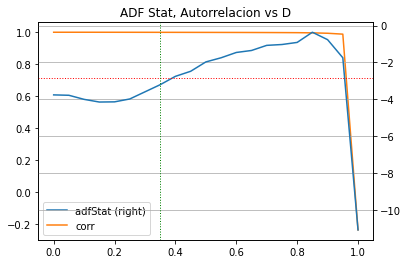

In [ ]:
#@title Diferenciación Fraccionaria del feature "Stock to Flow"
#@markdown Computamos una lista de valores de d (el grado de diferenciación),
#@markdown y diferenciamos la serie de precios.
ds = np.linspace(0, 1, 21)
# Agregamos como parámetro el nombre del feature a diferenciar
feature = 'S2F_365' # dfs2f['S2F_365']
# compute_multiple_ffd: Diferencia fraccionariamente y realiza test de Dickey Fuller
out = compute_multiple_ffd(df['S2F_365'].dropna().to_frame(), 1e-3, ds, feature)  # ['RollAvgIssContNtv_365']
print(out)

# Realizamos un plot para evaluar gráficamente el valor óptimo.
out[['adfStat','corr']].plot(secondary_y='adfStat')
mean_95conf = out['95% conf'].mean()
optim_d = get_d_optim(out, conf=0.05)
plt.axhline(mean_95conf,linewidth=1,color='r',linestyle='dotted')
plt.axvline(optim_d,linewidth=1,color='g',linestyle='dotted')
plt.grid()
plt.title('ADF Stat, Autorrelacion vs D')
print('Promedio de valores críticos para el estadístico al 5%: {}'.format(mean_95conf))
print('Valor óptimo de d: {}'.format(optim_d))

In [ ]:
df

,PriceUSD,AdrActCnt,HashRate,S2F_365
date,,,,
2010-07-18,0.085840,860.0,1.552225e-03,NaN
2010-07-19,0.080800,929.0,1.570274e-03,NaN
2010-07-20,0.074736,936.0,1.633446e-03,NaN
2010-07-21,0.079193,784.0,1.868085e-03,NaN
2010-07-22,0.058470,594.0,1.588324e-03,NaN
...,...,...,...,...
2021-03-26,54817.857112,1085835.0,1.478242e+08,49.554030
2021-03-27,56019.837306,1149403.0,1.728239e+08,49.681147
2021-03-28,55713.038140,1063472.0,1.728239e+08,49.775701


In [ ]:
# Corremos la serie difrenciada con la diferenciación fraccionaria óptima optim_d
# Overrideamos la variable para chequear que con otro nivel de diferenciación no nos queden valores negativos:
#optim_d = 1
df['S2F_Dif'] = fracDiff_FFD(df['S2F_365'].to_frame(), d=optim_d, thres=1e-3)
df
fig = px.line(df, x=df.index ,y='S2F_365')
fig.show()
fig = px.line(df, x=df.index ,y='S2F_Dif')
fig.show()

# Con estos dos gráficos queda demostrado que la serie diferenciada fracccionariamente se ve suavizada y sería estable en media y varianza.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: Dep

        adfStat          pVal  lags    nObs  95% conf      corr
0.00  -1.024766  7.441246e-01   1.0  2802.0 -2.862572  1.000000
0.05  -1.394129  5.850877e-01   1.0  2762.0 -2.862587  0.999697
0.10  -1.950744  3.085786e-01   1.0  2741.0 -2.862595  0.997862
0.15  -2.579626  9.728176e-02   1.0  2731.0 -2.862599  0.993490
0.20  -3.330391  1.357347e-02   1.0  2730.0 -2.862599  0.986139
0.25  -4.274809  4.910103e-04   1.0  2732.0 -2.862599  0.974797
0.30  -5.340320  4.515231e-06   1.0  2737.0 -2.862597  0.959077
0.35  -6.678153  4.411154e-09   1.0  2742.0 -2.862595  0.936777
0.40  -8.250180  5.417458e-13   1.0  2748.0 -2.862592  0.907724
0.45 -10.105550  1.032242e-17   1.0  2754.0 -2.862590  0.870234
0.50 -12.307286  7.223365e-23   1.0  2759.0 -2.862588  0.821068
0.55 -14.818466  1.980441e-27   1.0  2764.0 -2.862586  0.761694
0.60 -17.579473  4.014071e-30   1.0  2769.0 -2.862584  0.695090
0.65 -20.700035  0.000000e+00   1.0  2773.0 -2.862583  0.617015
0.70 -24.006750  0.000000e+00   1.0  277

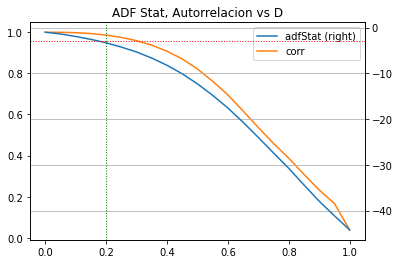

In [ ]:
#@title Diferenciación Fraccionaria Tasa de interés Bonos del Tesoro US (Fuente:FRED)
#@markdown Computamos una lista de valores de d (el grado de diferenciación),
#@markdown y diferenciamos la serie de precios.
#@markdown: elegimos la tasa de interés más adecuada:
#@markdown: - DGS2 tasa de 2 años
#@markdown: - DGS10 tasa de 10 años
#@markdown: - T10Y2Y diferencia entre la tasa de 2 y 10 años
ds = np.linspace(0, 1, 21)
# Agregamos como parámetro el nombre del feature a diferenciar
#feature = 'T10Y2Y' # df_with_fred['T10Y2Y']
#feature = 'DGS10' # df_with_fred['DGS10']
feature = 'DGS2' #@param ['DGS2', 'T10Y2Y', 'DGS10'] 


#MODIFICAMOS TEMPORALMENTE df_with_fred POR DF_FRED_FILTERED!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#SACAMOS DROPNA() ANTES DE TO_FRAME
# compute_multiple_ffd: Diferencia fraccionariamente y realiza test de Dickey Fuller
out = compute_multiple_ffd(df_fred_filtered[feature][1:].to_frame(), 1e-3, ds, feature)  # ['RollAvgIssContNtv_365']
print(out)

#out = compute_multiple_ffd(mtum['Close'].to_frame(), 1e-3, ds)


# Realizamos un plot para evaluar gráficamente el valor óptimo.
out[['adfStat','corr']].plot(secondary_y='adfStat')
mean_95conf = out['95% conf'].mean()
optim_d_yield = get_d_optim(out, conf=0.05) # mejorar codificación lista features con su correspondiente optimo
plt.axhline(mean_95conf,linewidth=1,color='r',linestyle='dotted')
plt.axvline(optim_d_yield,linewidth=1,color='g',linestyle='dotted')
plt.grid()
plt.title('ADF Stat, Autorrelacion vs D')
print('Promedio de valores críticos para el estadístico al 5%: {}'.format(mean_95conf))
print('Valor óptimo de d: {}'.format(optim_d_yield))

In [ ]:
# df_fred_filtered['DGS2'][1:].unique() 
df['yield_Dif'] = fracDiff_FFD(df_fred_filtered[feature].to_frame(), d=optim_d_yield, thres=1e-3)
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



,PriceUSD,AdrActCnt,HashRate,S2F_365,S2F_Dif,yield_Dif
date,,,,,,
2010-07-18,0.085840,860.0,1.552225e-03,NaN,NaN,NaN
2010-07-19,0.080800,929.0,1.570274e-03,NaN,NaN,NaN
2010-07-20,0.074736,936.0,1.633446e-03,NaN,NaN,NaN
2010-07-21,0.079193,784.0,1.868085e-03,NaN,NaN,NaN
2010-07-22,0.058470,594.0,1.588324e-03,NaN,NaN,NaN
...,...,...,...,...,...,...
2021-03-26,54817.857112,1085835.0,1.478242e+08,49.554030,9.045839,0.050732
2021-03-27,56019.837306,1149403.0,1.728239e+08,49.681147,9.085070,NaN
2021-03-28,55713.038140,1063472.0,1.728239e+08,49.775701,9.089799,NaN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: Dep

        adfStat          pVal  lags    nObs  95% conf      corr
0.00  -2.753232  6.527095e-02   1.0  3907.0 -2.862280  1.000000
0.05  -3.365559  1.219052e-02   1.0  3867.0 -2.862288  0.999843
0.10  -3.884467  2.152183e-03   1.0  3846.0 -2.862292  0.998894
0.15  -4.367963  3.380775e-04   1.0  3836.0 -2.862294  0.996344
0.20  -5.603672  1.248208e-06   1.0  3835.0 -2.862294  0.991296
0.25  -7.116594  3.816755e-10   1.0  3837.0 -2.862294  0.982063
0.30  -8.974799  7.582820e-15   1.0  3842.0 -2.862293  0.966968
0.35 -11.320935  1.174666e-20   1.0  3847.0 -2.862292  0.942943
0.40 -14.339020  1.067865e-26   1.0  3853.0 -2.862290  0.908348
0.45 -17.450083  4.657974e-30   1.0  3859.0 -2.862289  0.861762
0.50 -21.216642  0.000000e+00   1.0  3864.0 -2.862288  0.798587
0.55 -25.561242  0.000000e+00   1.0  3869.0 -2.862287  0.724597
0.60 -30.190121  0.000000e+00   1.0  3874.0 -2.862286  0.643094
0.65 -35.173148  0.000000e+00   1.0  3878.0 -2.862286  0.552637
0.70 -40.045296  0.000000e+00   1.0  388

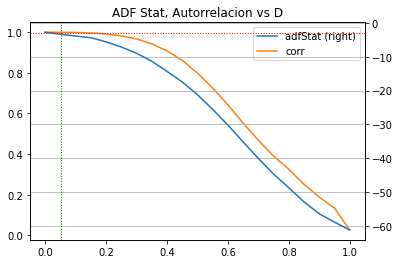

In [ ]:
#@title Diferenciación Fraccionaria del feature "Active Adresses Count"
#@markdown Computamos una lista de valores de d (el grado de diferenciación),
#@markdown y diferenciamos la serie de precios.
ds = np.linspace(0, 1, 21)
# Agregamos como parámetro el nombre del feature a diferenciar
feature = 'AdrActCnt' # df['AdrActCnt']
# compute_multiple_ffd: Diferencia fraccionariamente y realiza test de Dickey Fuller
out = compute_multiple_ffd(df['AdrActCnt'].dropna().to_frame(), 1e-3, ds, feature)  # ['RollAvgIssContNtv_365']
print(out)

# Realizamos un plot para evaluar gráficamente el valor óptimo.
out[['adfStat','corr']].plot(secondary_y='adfStat')
mean_95conf = out['95% conf'].mean()
optim_d = get_d_optim(out, conf=0.05)
plt.axhline(mean_95conf,linewidth=1,color='r',linestyle='dotted')
plt.axvline(optim_d,linewidth=1,color='g',linestyle='dotted')
plt.grid()
plt.title('ADF Stat, Autorrelacion vs D')
print('Promedio de valores críticos para el estadístico al 5%: {}'.format(mean_95conf))
print('Valor óptimo de d: {}'.format(optim_d))

In [ ]:
df['AdrActCnt'] = fracDiff_FFD(df['AdrActCnt'].to_frame(), d=optim_d, thres=1e-3)
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



,PriceUSD,AdrActCnt,HashRate,S2F_365,S2F_Dif,yield_Dif
date,,,,,,
2010-07-18,0.085840,NaN,1.552225e-03,NaN,NaN,NaN
2010-07-19,0.080800,NaN,1.570274e-03,NaN,NaN,NaN
2010-07-20,0.074736,NaN,1.633446e-03,NaN,NaN,NaN
2010-07-21,0.079193,NaN,1.868085e-03,NaN,NaN,NaN
2010-07-22,0.058470,NaN,1.588324e-03,NaN,NaN,NaN
...,...,...,...,...,...,...
2021-03-26,54817.857112,859040.608551,1.478242e+08,49.554030,9.045839,0.050732
2021-03-27,56019.837306,927840.041049,1.728239e+08,49.681147,9.085070,NaN
2021-03-28,55713.038140,840940.783298,1.728239e+08,49.775701,9.089799,NaN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: Dep

        adfStat          pVal  lags    nObs  95% conf      corr
0.00  -4.387068  3.128718e-04   1.0  3907.0 -2.862280  1.000000
0.05  -3.354844  1.259801e-02   1.0  3867.0 -2.862288  0.999992
0.10  -2.709765  7.236368e-02   1.0  3846.0 -2.862292  0.999934
0.15  -2.326982  1.634132e-01   1.0  3836.0 -2.862294  0.999779
0.20  -2.170271  2.172119e-01   1.0  3835.0 -2.862294  0.999489
0.25  -2.180531  2.133873e-01   1.0  3837.0 -2.862294  0.998986
0.30  -2.407406  1.396571e-01   1.0  3842.0 -2.862293  0.998190
0.35  -2.659155  8.137683e-02   1.0  3847.0 -2.862292  0.996870
0.40  -3.159696  2.243939e-02   1.0  3853.0 -2.862290  0.994820
0.45  -3.814668  2.760755e-03   1.0  3859.0 -2.862289  0.991608
0.50  -4.637972  1.098790e-04   1.0  3864.0 -2.862288  0.986309
0.55  -5.746677  6.098694e-07   1.0  3869.0 -2.862287  0.978065
0.60  -7.083034  4.613522e-10   1.0  3874.0 -2.862286  0.965446
0.65  -9.055815  4.705026e-15   1.0  3878.0 -2.862286  0.944968
0.70 -11.308598  1.255224e-20   1.0  388

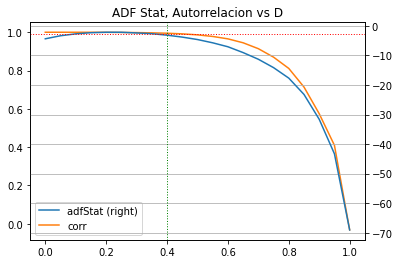

In [ ]:
#@title Diferenciación Fraccionaria del feature "Hash Rate"
#@markdown Computamos una lista de valores de d (el grado de diferenciación),
#@markdown y diferenciamos la serie de precios.
ds = np.linspace(0, 1, 21)
# Agregamos como parámetro el nombre del feature a diferenciar
feature = 'HashRate' # df['HashRate']
# compute_multiple_ffd: Diferencia fraccionariamente y realiza test de Dickey Fuller
out = compute_multiple_ffd(df['HashRate'].dropna().to_frame(), 1e-3, ds, feature)  # ['RollAvgIssContNtv_365']
print(out)

# Realizamos un plot para evaluar gráficamente el valor óptimo.
out[['adfStat','corr']].plot(secondary_y='adfStat')
mean_95conf = out['95% conf'].mean()
optim_d = get_d_optim(out, conf=0.05)
plt.axhline(mean_95conf,linewidth=1,color='r',linestyle='dotted')
plt.axvline(optim_d,linewidth=1,color='g',linestyle='dotted')
plt.grid()
plt.title('ADF Stat, Autorrelacion vs D')
print('Promedio de valores críticos para el estadístico al 5%: {}'.format(mean_95conf))
print('Valor óptimo de d: {}'.format(optim_d))

In [ ]:
df['HashRate'] = fracDiff_FFD(df['HashRate'].to_frame(), d=optim_d, thres=1e-3)
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



,PriceUSD,AdrActCnt,HashRate,S2F_365,S2F_Dif,yield_Dif
date,,,,,,
2010-07-18,0.085840,NaN,NaN,NaN,NaN,NaN
2010-07-19,0.080800,NaN,NaN,NaN,NaN,NaN
2010-07-20,0.074736,NaN,NaN,NaN,NaN,NaN
2010-07-21,0.079193,NaN,NaN,NaN,NaN,NaN
2010-07-22,0.058470,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2021-03-26,54817.857112,859040.608551,5.169884e+06,49.554030,9.045839,0.050732
2021-03-27,56019.837306,927840.041049,3.781302e+07,49.681147,9.085070,NaN
2021-03-28,55713.038140,840940.783298,2.998798e+07,49.775701,9.089799,NaN


In [ ]:
#@title Joineamos Dummies de Halvings:
df = df.join(pd.DataFrame(halvings_df), on="date", how="left")
df= df.dropna()
df

,PriceUSD,AdrActCnt,HashRate,S2F_365,S2F_Dif,yield_Dif,BTC Launch,First Halving,Second Halving,Third Halving,Around Halving
date,,,,,,,,,,,
2011-08-29,8.961157,14755.656909,2.430491e+00,2.168728,0.393888,0.042681,1,0,0,0,0
2011-08-30,8.809949,13318.254732,2.381187e+00,2.171039,0.393337,0.045280,1,0,0,0,0
2011-08-31,8.199152,13264.110091,2.805950e+00,2.174343,0.394074,0.047177,1,0,0,0,0
2011-09-01,8.234282,12783.365541,9.506943e-02,2.177224,0.394157,0.038744,1,0,0,0,0
2011-09-02,8.621424,12638.264147,3.253967e+00,2.179590,0.393836,0.052125,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2021-03-24,52595.411324,927609.890473,2.050947e+07,49.373895,8.986014,0.048123,0,0,0,1,1
2021-03-25,51547.124895,994269.627104,2.522982e+07,49.400946,8.942700,0.050059,0,0,0,1,1
2021-03-26,54817.857112,859040.608551,5.169884e+06,49.554030,9.045839,0.050732,0,0,0,1,1


## Eventos para usar en Bet Sizing
*Generación* de los eventos para el modelo de 

In [ ]:
# Obtenemos los labels! Los labels nos dan la siguiente informacion:
# - Indice: momento en el que ocurre el evento segun nuestra estrategia.
# - Columna ret: el retorno que vamos a obtener.
# - Columna bin: lo que sucede con la señal de la apuesta:
#   - 1: se toma la apuesta.
#   - 0: no se toma la apuesta.
labels = getBins(triple_barrier_events, df['PriceUSD'])
labels

#getBins: con el bin que genera nos indica si entrar o no entrar

,ret,bin
date,,
2010-07-31,0.000000,0.0
2010-08-01,-0.000000,0.0
2010-08-09,0.000000,0.0
2010-08-25,-0.000000,0.0
2010-09-21,0.000000,0.0
...,...,...
2021-02-02,0.055686,1.0
2021-02-27,-0.000000,0.0
2021-03-03,-0.043749,0.0


In [ ]:
# Una pequeña tabla de contención que nos indica como se distribuyen
# los bins de los labels, tengo 187 bins
labels['bin'].value_counts()

0.0    132
1.0     57
Name: bin, dtype: int64

# Sample Weights: Cálculo de la unicidad de las muestras


In [ ]:
#@markdown - Concurrent labels: 2 labels son concurrentes en algun t, cuando los dos son función de al menos un mismo retorno comun.
#@markdown - mpNumCoEvents: computa el número de eventos concurrentes por barrera
#@markdonw - t1 es la serie en donde se toca alguna barrera
# Obtengo los coeficientes de concurrencia para cada evento.
numCoEvents = mpPandasObj(mpNumCoEvents,('molecule',triple_barrier_events.index),cpus,
                          closeIdx=df.index,t1=triple_barrier_events['t1'])
numCoEvents = numCoEvents.loc[~numCoEvents.index.duplicated(keep='last')]
numCoEvents = numCoEvents.reindex(df['PriceUSD'].index).fillna(0)

# Genero un data frame que contenga en una columna los pesos por concurrencia
# y en otra los pesos por concurrencia + retornos.
out=pd.DataFrame()
out['tW'] = mpPandasObj(mpSampleTW,('molecule',triple_barrier_events.index),cpus,
                        t1=triple_barrier_events['t1'],numCoEvents=numCoEvents)
out['w'] = mpPandasObj(mpSampleW,('molecule',triple_barrier_events.index),cpus,
                       t1=triple_barrier_events['t1'],numCoEvents=numCoEvents,close=df['PriceUSD'])
out['w'] *= out.shape[0]/out['w'].sum()
out

#out['tW'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



,tW,w
2010-07-31,NaN,0.000000
2010-08-01,NaN,0.000000
2010-08-09,NaN,0.000000
2010-08-25,NaN,0.000000
2010-09-21,NaN,0.000000
...,...,...
2021-02-02,1.0,3.457134
2021-02-27,NaN,0.000000
2021-03-03,1.0,0.106476
2021-03-24,1.0,1.743184


In [ ]:
averageUniqueness = out.mean()[0]
print('averageUniqueness:')
averageUniqueness

averageUniqueness:


0.9493006993006993

In [ ]:
# Genero un data frame entre las concurrencias y los desvios de retornos diarios.
coEvents_std = (pd.DataFrame().assign(numCoEvents = numCoEvents, std = target))
coEvents_std

,numCoEvents,std
date,,
2011-08-29,0.0,0.122587
2011-08-30,0.0,0.120204
2011-08-31,0.0,0.118774
2011-09-01,0.0,0.116900
2011-09-02,0.0,0.115294
...,...,...
2021-03-24,1.0,0.058924
2021-03-25,1.0,0.059125
2021-03-26,0.0,0.058372


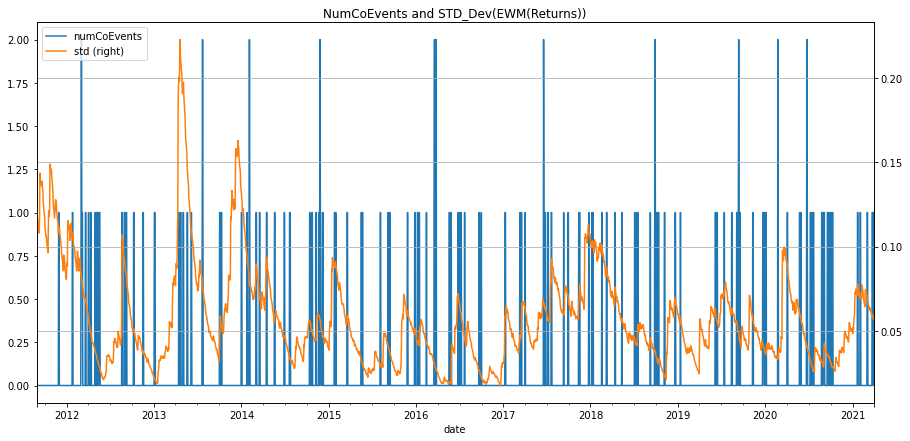

In [ ]:
# Evaluamos los retornos y las concurrencias en la serie temporal.
fig, ax = plt.subplots(figsize=(15,7))
coEvents_std['numCoEvents'].plot(legend=True, ax=ax)
coEvents_std['std'].plot(secondary_y=True, legend=True, ax=ax)
plt.title('NumCoEvents and STD_Dev(EWM(Returns))')
plt.grid()
plt.show()

# Modelling: Preparamos Parámetros y variables para los modelos:



In [ ]:
#@title Preparación de los X e Y para el modelo (todas las variables)
# Preparamos la información para introducirla en un modelo de ML.
Xy = (pd.merge_asof(triple_barrier_events, labels[['bin']],
                    left_index=True, right_index=True, 
                    direction='forward').dropna())
Xy = (pd.merge_asof(Xy, out.loc[Xy.index].w,
                    left_index=True, right_index=True, 
                    direction='forward').dropna())

# En esta parte agregamos nuevas features:
Xy = (pd.merge_asof(Xy, df[['S2F_Dif','yield_Dif','AdrActCnt']],#,'HashRate','BTC Launch', 'First Halving', 'Second Halving', 'Third Halving']],
                    left_index=True, right_index=True, 
                    direction='forward').dropna())

# Preparamos la informacion para introducirla en un modelo de ML.
X = Xy.copy()[['trgt', 'side', 'w','S2F_Dif','yield_Dif','AdrActCnt']].values#,'HashRate','BTC Launch', 'First Halving', 'Second Halving', 'Third Halving']].values
x = Xy.copy()[['trgt', 'side', 'w','S2F_Dif','yield_Dif','AdrActCnt']]#,'HashRate','BTC Launch', 'First Halving', 'Second Halving', 'Third Halving']]
y = Xy.copy().bin.values # labels.bin.values     # CHEQUEAR SI LOS BINS DE ANTES QUE INDICABAN SI HABIA Q ENTRAR O NO POR TRIPLE BARRIER SON LO MISMO QUE LAS Y QUE EESTAMOS GENERANDO ACÁ (ES CONFUSO QUE PARECE QUE USA UNA FUNCION NATIVA DE PYTHON "BINS" Y LA VARIABLE Y TAMBIÉN SE LLAMA ASÍ)
# Realizamos un train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, shuffle=False)

## Random Forest base ( target y side ) (rf)


Equally weighted sample weights


In [ ]:
# X va desde ['trgt', 'side', 'w','S2F_Dif','yield_Dif','AdrActCnt','HashRate','BTC Launch', 'First Halving', 'Second Halving', 'Third Halving']
# Usamos las 2 primeras:
X_train

array([[ 1.40587821e-01,  1.00000000e+00,  0.00000000e+00,
         3.93888044e-01,  4.26812011e-02,  1.47556569e+04],
       [ 1.33694089e-01, -1.00000000e+00,  0.00000000e+00,
         3.93888044e-01,  4.26812011e-02,  1.47556569e+04],
       [ 1.15241911e-01,  1.00000000e+00,  0.00000000e+00,
         3.93888044e-01,  4.26812011e-02,  1.47556569e+04],
       [ 7.91482199e-02, -1.00000000e+00,  0.00000000e+00,
         3.93888044e-01,  4.26812011e-02,  1.47556569e+04],
       [ 4.66997137e-02,  1.00000000e+00,  0.00000000e+00,
         3.93888044e-01,  4.26812011e-02,  1.47556569e+04],
       [ 4.56987203e-02, -1.00000000e+00,  0.00000000e+00,
         3.93888044e-01,  4.26812011e-02,  1.47556569e+04],
       [ 4.47396846e-02,  1.00000000e+00,  0.00000000e+00,
         3.93888044e-01,  4.26812011e-02,  1.47556569e+04],
       [ 3.85557062e-02, -1.00000000e+00,  0.00000000e+00,
         3.93888044e-01,  4.26812011e-02,  1.47556569e+04],
       [ 3.45402405e-02,  1.00000000e+00,  0.000

In [ ]:
# Hiperpametros
n_estimator = 1000     # Numero de arboles.
criterion = 'entropy' # Es un clasificador, necesitamos definir la metrica del modelo 
                      # que va a optimizar. Podria ser gini tambien.
max_depth = 2         # Numero de niveles que va a tener cada arbol. Al elegir un split binario
                      # permitimos que el entrenamiento sea mas lento.
n_jobs = 4            # Numero de threads que van a abrirse para entrenar mas rapido.
# Para mas argumentos, revisar https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
rf = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimator,
                            criterion=criterion, n_jobs=n_jobs, random_state=123)
rf.fit(X_train[:,0:2], y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=4, oob_score=False, random_state=123, verbose=0,
                       warm_start=False)

Classification report
              precision    recall  f1-score   support

         0.0       0.68      0.85      0.76       100
         1.0       0.44      0.23      0.30        52

    accuracy                           0.64       152
   macro avg       0.56      0.54      0.53       152
weighted avg       0.60      0.64      0.60       152

Accuracy
0.6381578947368421


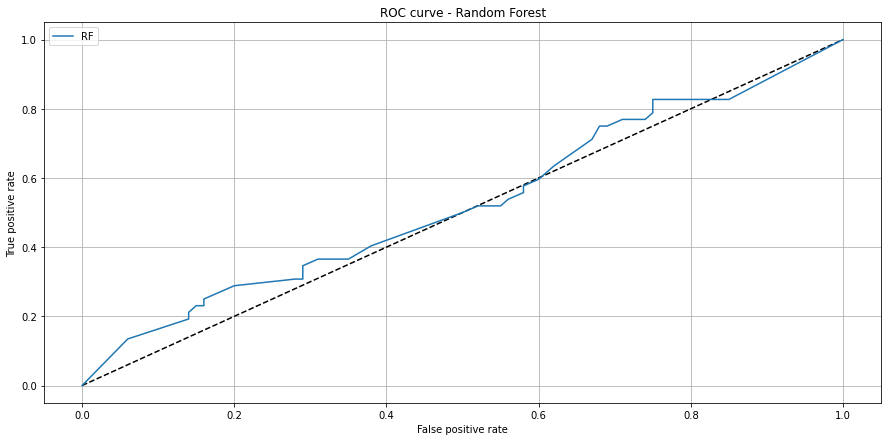

In [ ]:
# Predecimos con el test set y contrastamos.
y_pred_rf_prob = rf.predict_proba(X_test[:,0:2])[:, 1]
y_pred_rf = rf.predict(X_test[:,0:2])

# Realizamos un reporte de la clasificacion y realizamos una ROC.
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf_prob)
print("Classification report")
print(classification_report(y_test, y_pred_rf))

print("Accuracy")
print(accuracy_score(y_test, y_pred_rf))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - Random Forest')
plt.legend(loc='best')
plt.grid()
plt.show()

## Random Forest con uniqueness (rf1)
Sin features, con sample weights

In [ ]:
# Hiperpametros
n_estimator = 1000     # Numero de arboles.
criterion = 'entropy' # Es un clasificador, necesitamos definir la metrica del modelo 
                      # que va a optimizar. Podria ser gini tambien.
max_depth = 2         # Numero de niveles que va a tener cada arbol. Al elegir un split binario
                      # permitimos que el entrenamiento sea mas lento.
n_jobs = 4            # Numero de threads que van a abrirse para entrenar mas rapido.
# Para mas argumentos, revisar https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
rf1 = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimator,
                             criterion=criterion, n_jobs=n_jobs, random_state=123)
rf1.fit(X_train[:,0:2], y_train, sample_weight=X_train[:,3])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=4, oob_score=False, random_state=123, verbose=0,
                       warm_start=False)

Classification report
              precision    recall  f1-score   support

         0.0       0.68      0.85      0.76       100
         1.0       0.44      0.23      0.30        52

    accuracy                           0.64       152
   macro avg       0.56      0.54      0.53       152
weighted avg       0.60      0.64      0.60       152

Accuracy
0.6381578947368421


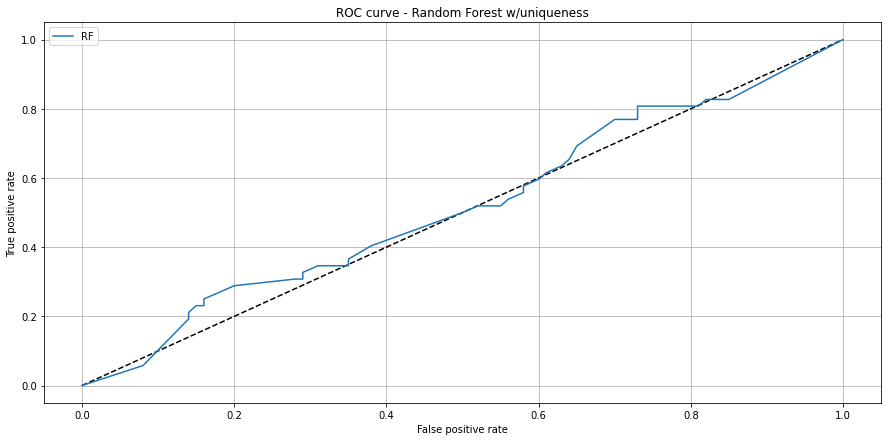

In [ ]:
# Predecimos con el test set y contrastamos.
y_pred_rf1_prob = rf1.predict_proba(X_test[:,0:2])[:, 1]
y_pred_rf1 = rf1.predict(X_test[:,0:2])

# Realizamos un reporte de la clasificacion y realizamos una ROC.
fpr_rf1, tpr_rf1, _ = roc_curve(y_test, y_pred_rf1_prob)
print("Classification report")
print(classification_report(y_test, y_pred_rf1))

print("Accuracy")
print(accuracy_score(y_test, y_pred_rf1))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf1, tpr_rf1, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - Random Forest w/uniqueness')
plt.legend(loc='best')
plt.grid()
plt.show()

## **Random Forest con Features (rf2)**




In [ ]:
# Hiperpametros
n_estimator = 1000     # Numero de arboles.
criterion = 'entropy' # Es un clasificador, necesitamos definir la metrica del modelo 
                      # que va a optimizar. Podria ser gini tambien.
max_depth = 2         # Numero de niveles que va a tener cada arbol. Al elegir un split binario
                      # permitimos que el entrenamiento sea mas lento.
n_jobs = 4            # Numero de threads que van a abrirse para entrenar mas rapido.
# Para mas argumentos, revisar https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
rf2 = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimator,
                             criterion=criterion, n_jobs=n_jobs, random_state=123)
rf2.fit(X_train, y_train, sample_weight=X_train[:,3])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=4, oob_score=False, random_state=123, verbose=0,
                       warm_start=False)

Classification report
              precision    recall  f1-score   support

         0.0       0.68      0.98      0.80       100
         1.0       0.71      0.10      0.17        52

    accuracy                           0.68       152
   macro avg       0.70      0.54      0.48       152
weighted avg       0.69      0.68      0.58       152

Accuracy
0.6776315789473685


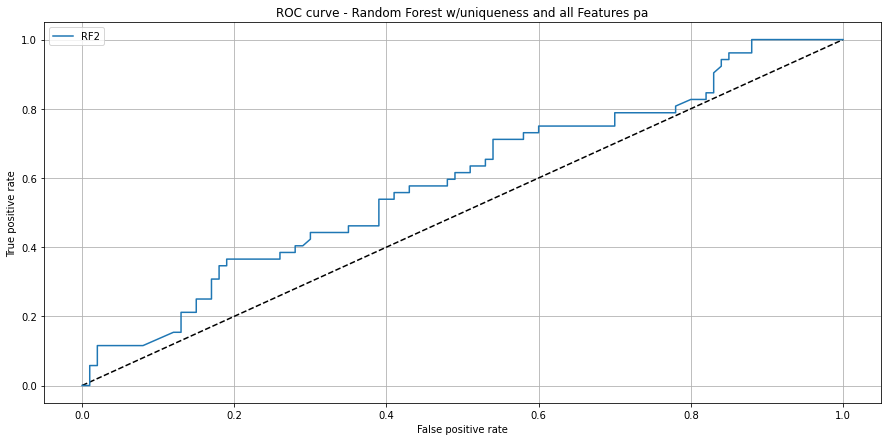

In [ ]:
# Predecimos con el test set y contrastamos.
y_pred_rf2_prob = rf2.predict_proba(X_test)[:, 1]
y_pred_rf2 = rf2.predict(X_test)

# Realizamos un reporte de la clasificacion y realizamos una ROC.
fpr_rf2, tpr_rf2, _ = roc_curve(y_test, y_pred_rf2_prob)
print("Classification report")
print(classification_report(y_test, y_pred_rf2))

print("Accuracy")
print(accuracy_score(y_test, y_pred_rf2))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf2, tpr_rf2, label='RF2')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - Random Forest w/uniqueness and all Features pa')
plt.legend(loc='best')
plt.grid()
plt.show()

Vemos que con features si bien no mejora accuracy, mejora significativamente el area bajo la curva, es decir es más potente en términos de predicción vs la aleatoriedad.

In [ ]:
rf2.score(X_test, y_test)

0.6776315789473685

## Bagging base

In [ ]:
# Usamos bagging ahora
# Hiperpametros
n_estimator = 1000    # Numero de arboles.
max_samples = 0.5     # Porcion del data set a samplear para cada arbol.
criterion = 'entropy' # Es un clasificador, necesitamos definir la metrica del modelo 
                      # que va a optimizar. Podria ser gini tambien.
n_jobs = 4            # Numero de threads que van a abrirse para entrenar mas rapido.
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html
bc = BaggingClassifier(max_samples=max_samples, n_estimators=n_estimator,
                       n_jobs=n_jobs, random_state=123)
bc.fit(X_train[:,0:2], y_train)

BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=0.5, n_estimators=1000,
                  n_jobs=4, oob_score=False, random_state=123, verbose=0,
                  warm_start=False)

Classification report
              precision    recall  f1-score   support

         0.0       0.68      0.84      0.75       100
         1.0       0.45      0.25      0.32        52

    accuracy                           0.64       152
   macro avg       0.57      0.54      0.54       152
weighted avg       0.60      0.64      0.61       152

Accuracy
0.6381578947368421


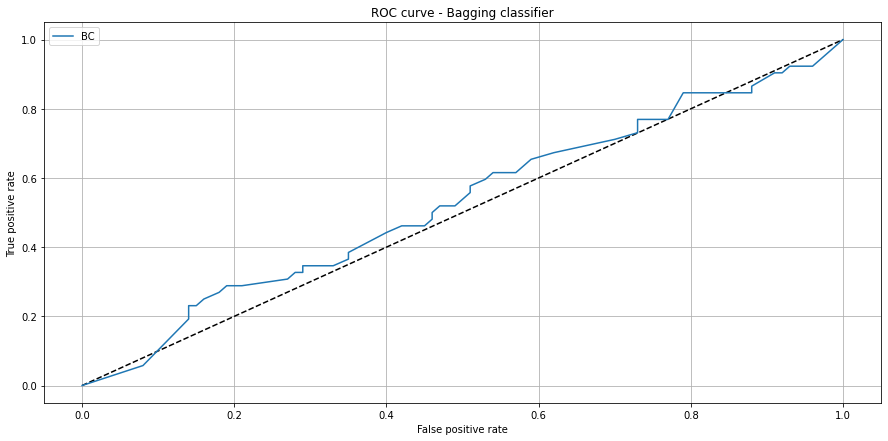

In [ ]:
# Predecimos con el test set y contrastamos.
y_pred_bc_prob = bc.predict_proba(X_test[:,0:2])[:, 1]
y_pred_bc = bc.predict(X_test[:,0:2])

# Realizamos un reporte de la clasificacion y realizamos una ROC.
fpr_bc, tpr_bc, _ = roc_curve(y_test, y_pred_bc_prob)
print('Classification report')
print(classification_report(y_test, y_pred_bc))

print("Accuracy")
print(accuracy_score(y_test, y_pred_bc))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_bc, tpr_bc, label='BC')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - Bagging classifier')
plt.legend(loc='best')
plt.grid()
plt.show()

## Bagging con uniqueness I

In [ ]:
# Usamos bagging ahora
# Hiperpametros
n_estimator = 1000    # Numero de arboles.
max_samples = averageUniqueness     # Porcion del data set a samplear para cada arbol.
criterion = 'entropy' # Es un clasificador, necesitamos definir la metrica del modelo 
                      # que va a optimizar. Podria ser gini tambien.
n_jobs = 4            # Numero de threads que van a abrirse para entrenar mas rapido.
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html
bc2 = BaggingClassifier(max_samples=max_samples, n_estimators=n_estimator,
                       n_jobs=n_jobs, random_state=123)
bc2.fit(X_train[:,0:2], y_train)

BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=0.9493006993006993,
                  n_estimators=1000, n_jobs=4, oob_score=False,
                  random_state=123, verbose=0, warm_start=False)

Classification report
              precision    recall  f1-score   support

         0.0       0.67      0.73      0.70       100
         1.0       0.37      0.31      0.34        52

    accuracy                           0.59       152
   macro avg       0.52      0.52      0.52       152
weighted avg       0.57      0.59      0.57       152

Accuracy
0.5855263157894737


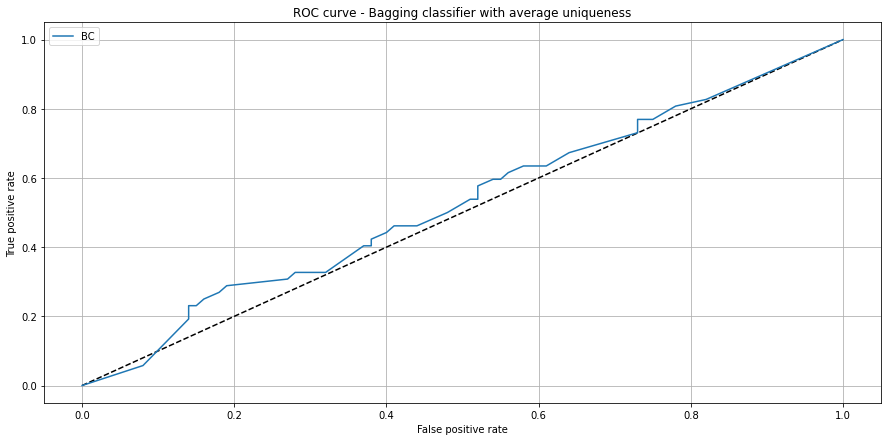

In [ ]:
# Predecimos con el test set y contrastamos.
y_pred_bc2_prob = bc2.predict_proba(X_test[:,0:2])[:, 1]
y_pred_bc2 = bc2.predict(X_test[:,0:2])

# Realizamos un reporte de la clasificacion y realizamos una ROC.
fpr_bc2, tpr_bc2, _ = roc_curve(y_test, y_pred_bc2_prob)
print("Classification report")
print(classification_report(y_test, y_pred_bc2))

print("Accuracy")
print(accuracy_score(y_test, y_pred_bc2))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_bc2, tpr_bc2, label='BC')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - Bagging classifier with average uniqueness')
plt.legend(loc='best')
plt.grid()
plt.show()

## Bagging con uniqueness II

In [ ]:
# Usamos bagging ahora
# Hiperpametros
n_estimator = 1000    # Numero de arboles.
max_samples = 0.5     # Porcion del data set a samplear para cada arbol.
criterion = 'entropy' # Es un clasificador, necesitamos definir la metrica del modelo 
                      # que va a optimizar. Podria ser gini tambien.
n_jobs = 4            # Numero de threads que van a abrirse para entrenar mas rapido.
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html
bc3 = BaggingClassifier(max_samples=max_samples, n_estimators=n_estimator,
                       n_jobs=n_jobs, random_state=123)
bc3.fit(X_train[:,0:2], y_train, sample_weight=X_train[:,2])

BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=0.5, n_estimators=1000,
                  n_jobs=4, oob_score=False, random_state=123, verbose=0,
                  warm_start=False)

Classification report
              precision    recall  f1-score   support

         0.0       0.70      0.80      0.75       100
         1.0       0.47      0.35      0.40        52

    accuracy                           0.64       152
   macro avg       0.59      0.57      0.57       152
weighted avg       0.62      0.64      0.63       152

Accuracy
0.6447368421052632


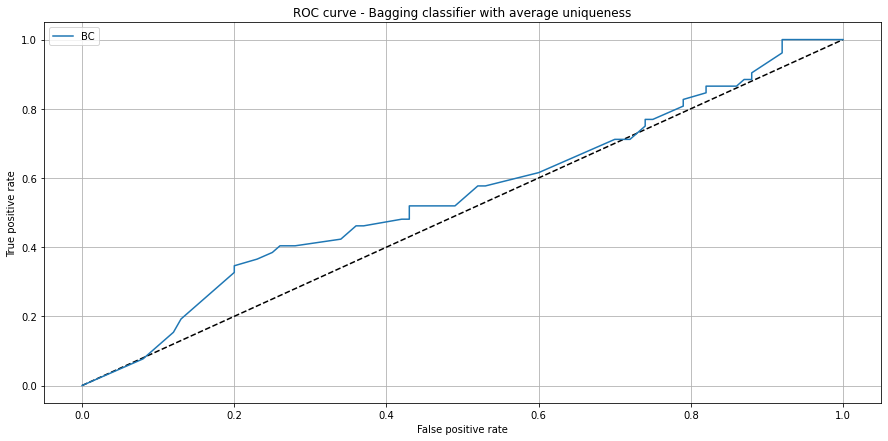

In [ ]:
# Predecimos con el test set y contrastamos.
y_pred_bc3_prob = bc3.predict_proba(X_test[:,0:2])[:, 1]
y_pred_bc3 = bc3.predict(X_test[:,0:2])

# Realizamos un reporte de la clasificacion y realizamos una ROC.
fpr_bc3, tpr_bc3, _ = roc_curve(y_test, y_pred_bc3_prob)
print("Classification report")
print(classification_report(y_test, y_pred_bc3))

print("Accuracy")
print(accuracy_score(y_test, y_pred_bc3))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_bc3, tpr_bc3, label='BC')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - Bagging classifier with average uniqueness')
plt.legend(loc='best')
plt.grid()
plt.show()

## Cross Validation (Tradicional, sin Embargo y Purga)

In [ ]:
CV_SPLITS = 5

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:153: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:153: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:153: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:153: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/usr/local/lib/python3.7/dist-pa

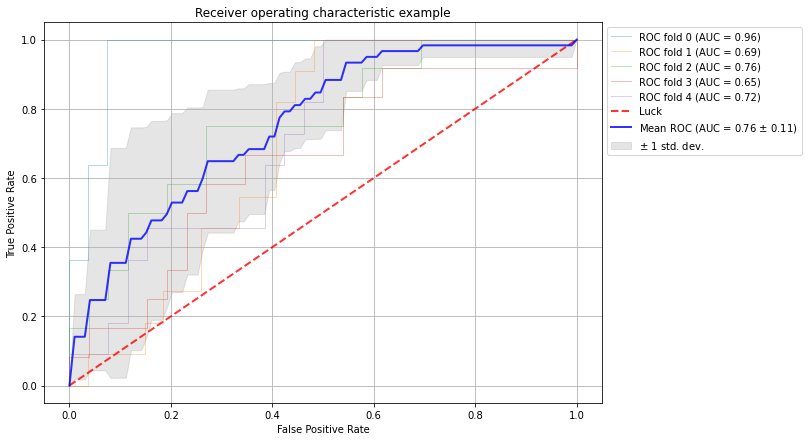

In [ ]:
# Hiperpametros
n_estimator = 1000     # Numero de arboles.
criterion = 'entropy' # Es un clasificador, necesitamos definir la metrica del modelo 
                      # que va a optimizar. Podria ser gini tambien.
max_depth = 2         # Numero de niveles que va a tener cada arbol. Al elegir un split binario
                      # permitimos que el entrenamiento sea mas lento.
n_jobs = 4            # Numero de threads que van a abrirse para entrenar mas rapido.

skf = StratifiedKFold(n_splits=CV_SPLITS, shuffle=False, random_state=123)
rf_skf = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimator,
                                criterion=criterion, n_jobs=n_jobs, random_state=123)
crossValPlot(skf,rf_skf,X,y)

## Cross validation del modelo (con Embargo y Purga)


In [ ]:
# Buscamos un mejor modelo, entrenado con CV + Embargo.
PCT_EMBARGO = 0.01 # En porcentaje

# Hiperparámetros
n_estimator = 1000    # Numero de arboles.
criterion = 'entropy' # Es un clasificador, necesitamos definir la metrica del modelo 
                      # que va a optimizar. Podria ser gini tambien.
max_depth = 2         # Numero de niveles que va a tener cada arbol. Al elegir un split binario
                      # permitimos que el entrenamiento sea mas lento.
n_jobs = 4            # Numero de threads que van a abrirse para entrenar mas rapido.
# Para mas argumentos, revisar https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

rf_pkf = RandomForestClassifier(max_depth = max_depth, 
                                n_estimators = n_estimator,
                                criterion = criterion, 
                                n_jobs = n_jobs, 
                                random_state = 123)

pkf = PurgedKFold(n_splits = CV_SPLITS, 
                  t1 = t1, 
                  pctEmbargo = PCT_EMBARGO)

# crossValPlot2(pkf,rf_pkf,x,Xy.copy().bin)   #def crossValPlot2(skf,classifier,X,y):


## Optimización de Hiperparámetros

En este bloque realizamos la optimización de los siguientes hiperparámetros relevantes para un Random Forest:

*   n_estimator: Numero de arboles (hiperparámetro clave)
*   max_depth: Numero de niveles que va a tener cada arbol.



In [ ]:
#@title Hiperparámetros originales del modelo completo (RF2)
print('Parámetros del modelo actuales:\n')
print(rf2.get_params())

Parámetros del modelo actuales:

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1000, 'n_jobs': 4, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False}


In [ ]:
#@title Random Search CV
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
# Número de árboles en el Random Forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 39)]
# Máxima profundidad en niveles que va a tener cada árbol
max_depth = [int(x) for x in np.linspace(2, 20, num = 19)]
max_depth.append(None)
# Número de features a considerar en cada split (auto=sqrt= max features = sqrt(n_features), log2: max_features=log2(n_features), none: max_features=n_features)
max_features = ['auto', 'log2', 'none']

# Creamos la grilla:
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth}
print('Grilla:')
print(random_grid)

# Usamos la grilla para tunear los hiperparámetros de RF2

# Para el random search usamos k-fold CV, usamos 5 fold cross validation (cv=5), 
# usando 100 diferentes combinaciones y usando (cores=-1) todos los nucleos

rf2_randomsearch = RandomizedSearchCV(estimator = rf2,
                                      param_distributions = random_grid,
                                      n_iter = 100,
                                      cv = 5,
                                      verbose=3,
                                      random_state=123,
                                      n_jobs = -1)
# Fit the random search model
rf2_randomsearch.fit(X_train, y_train)

Grilla:
{'n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550, 1600, 1650, 1700, 1750, 1800, 1850, 1900, 1950, 2000], 'max_features': ['auto', 'log2', 'none'], 'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, None]}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  7.4min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='entropy',
                                                    max_depth=2,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
#@title Mejor modelo con random search
best_randomsearch = rf2_randomsearch.best_estimator_
best_randomsearch

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=4,
                       oob_score=False, random_state=123, verbose=0,
                       warm_start=False)

In [ ]:
#@title GridSearch CV. Mejor modelo con gridsearch:
#@markdown: Random search permite acercar de forma aleatoria
#@markdown: a los mejores hiperparámetros, sobre eso aplicamos GridSearch CV
#@markdown: para ajustar y enfocar la búsqueda:
param_grid = {'max_depth': [2, 3, 4, 5, 6],
              'max_features': ['auto'],
              'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]}

rf2_gridsearch = GridSearchCV(estimator = rf2, param_grid = param_grid, 
                          cv = 2, n_jobs = -1, verbose = 3)
rf2_gridsearch.fit(X_train, y_train)
best_gridsearch = rf2_gridsearch.best_estimator_
best_gridsearch

Fitting 2 folds for each of 60 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.7min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
                       oob_score=False, random_state=123, verbose=0,
                       warm_start=False)

Classification report
              precision    recall  f1-score   support

         0.0       0.68      0.97      0.80       100
         1.0       0.67      0.12      0.20        52

    accuracy                           0.68       152
   macro avg       0.67      0.54      0.50       152
weighted avg       0.67      0.68      0.59       152

Accuracy
0.6776315789473685


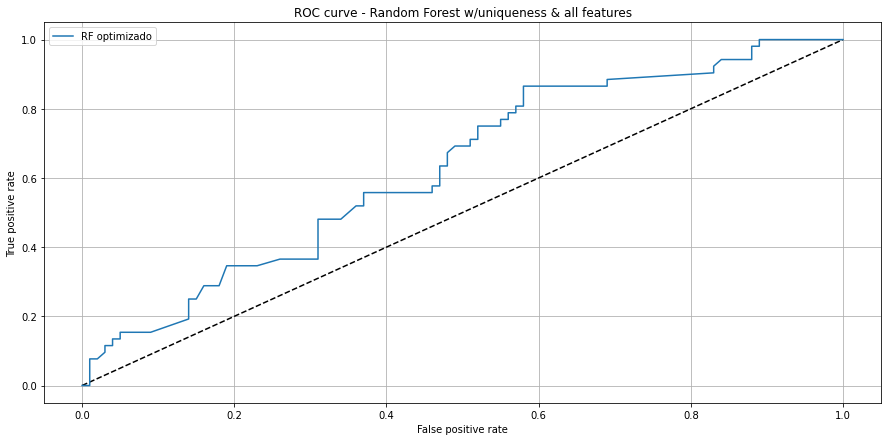

In [ ]:
#@title Reseteamos las predicciones post tuning de Hiperparámetros
# Pisamos las predicciones de RF2 con
y_pred_rf2_prob = best_gridsearch.predict_proba(X_test)[:, 1]
y_pred_rf2 = best_gridsearch.predict(X_test)

# Realizamos un reporte de la clasificacion y realizamos una ROC.
fpr_rf2, tpr_rf2, _ = roc_curve(y_test, y_pred_rf2_prob)
print("Classification report")
print(classification_report(y_test, y_pred_rf2))

print("Accuracy")
print(accuracy_score(y_test, y_pred_rf2))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf2, tpr_rf2, label='RF optimizado')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - Random Forest w/uniqueness & all features')
plt.legend(loc='best')
plt.grid()
plt.show()

# Bet Sizing - Dimensionamiento de la apuesta (en \$) 

In [ ]:
# Tomamos las predicciones de un modelo, y modelamos el size del bet 
# a partir de la probabilidad.
# Predecimos con el test set y contrastamos.
NUM_CLASSES=2
JOBS=4

NUM_STEPS=5
STEP_SIZE=1/NUM_STEPS 

# Las probabilidades y las predicciones tienen que ser series indexadas
# y apareadas con events (Xy).

# x.values es compatible con el modelo sin features
# X es compatible con el modelo con todos los features que le agregamos

x = Xy.copy()[['trgt', 'side']]
y_prob_df = pd.Series(data=best_randomsearch.predict_proba(X)[:, 1], index=x.index)
y_pred_df = pd.Series(data=best_randomsearch.predict(X), index=x.index)

# Se utiliza el modelo best_randomsearch con los hiperparámetros optimizados con kfold cv Random Search

bets = getSignal(triple_barrier_events, STEP_SIZE, y_prob_df, y_pred_df, NUM_CLASSES, JOBS)

# La función getSignal produce las probabilidades de Random Forest, que luego son transformadas a un SIZE en $
# Toma como argumentos:
# events: nosotros usamos triple_barrier_events: df con lo de abajo. Sin embargo la función después opera solo con el side
          #Fecha inicio fecha fin retorno side
          #2010-07-31	2010-08-01	0.140588	1
# prob: nosotros pusimos y_prob_df que es la serie de probabilidades que surgen del método predict proba de random forest. De la tupla (prob1; prob0) nos quedamos con la prob de que sea clase 1, no 0)
            #Predict class probabilities for X. Con el rf del ayudante podemos observar que varios casos pasa 60%, en el nuestro no
# pred: nostros usamos la prediccion de nuestro modelo. Predict class for X.


print('Bet size with respect to the total budget:')
print(bets)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



Bet size with respect to the total budget:
2010-07-31    0.0
2010-08-01    0.0
2010-08-02    0.0
2010-08-09    0.0
2010-08-10    0.0
             ... 
2021-03-04    0.0
2021-03-24    0.0
2021-03-25    0.0
2021-03-29    0.0
2021-03-30    0.0
Length: 361, dtype: float64


2021-04-01 02:11:35.162205 100.0% mpAvgActiveSignals done after 0.01 minutes. Remaining 0.0 minutes.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



In [ ]:
y_pred_df

date
2010-07-31    0.0
2010-08-01    0.0
2010-08-09    0.0
2010-08-25    0.0
2010-09-21    0.0
             ... 
2021-02-02    0.0
2021-02-27    0.0
2021-03-03    0.0
2021-03-24    0.0
2021-03-29    0.0
Length: 189, dtype: float64

In [ ]:

#if y_prob_df.shape[0] == 0: return pd.Series()
#1) Generate signals from multinomial classification (one vs rest, OvR)
# t-value of OvR
signal0 = (y_prob_df - 1. / 2) / ((1. / 2) * (1. - (1. / 2)))**0.5
signal0
# signal = side * size
#signal0 = pred * (2 * norm._cdf(signal0) - 1)


#if 'side' in triple_barrier_events: signal0 *= triple_barrier_events.loc[signal0.index, 'side']
#2) Compute average signal among those concurrently open
#df0 = signal0.to_frame('signal').join(events[['t1']], how='left')
#df0 = avgActiveSignals(df0, numThreads)
#signal1 = discreteSignal(signal0=df0, stepSize=stepSize)
    
for i in signal0:
  print(i)

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-0.96
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.5333333333333334
0.3666666666666667
-0.8933333333333333
-0.7
-0.7511111111111111
0.45333333333333337
-0.6355555555555557
-0.8355555555555556
-0.92
-0.731111111111111
-0.84
0.4933333333333334
0.5266666666666666
-0.8833333333333333
-0.85
-0.9033333333333333
-0.96
-0.7633333333333333
-0.61
-0.30666666666666664
-0.31999999999999995
-0.6233333333333333
-0.6366666666666667
-0.6233333333333333
-0.8266666666666667
-0.7333333333333334
-0.8533333333333333
-0.96
-0.7633333333333333
-0.6766666666666667
-0.6033333333333333
-0.7733333333333333
-0.6833333333333333
-0.7633333333333333
-0.8266666666666667
-0.7966666666666666
-0.8533333333333333
-0.7233333333333334
-0.8166666666666667
-0.6933333333333334
-0.75
-0.6133333333333333
-0.42000000000000004
0.006666666666666599
-0.84
-0.6833333333333333
-0.42000000000000004
-0.44666666666666666
-0.6133333333333333
-0.6266666666666667
-0.6699999999999999
-0.42

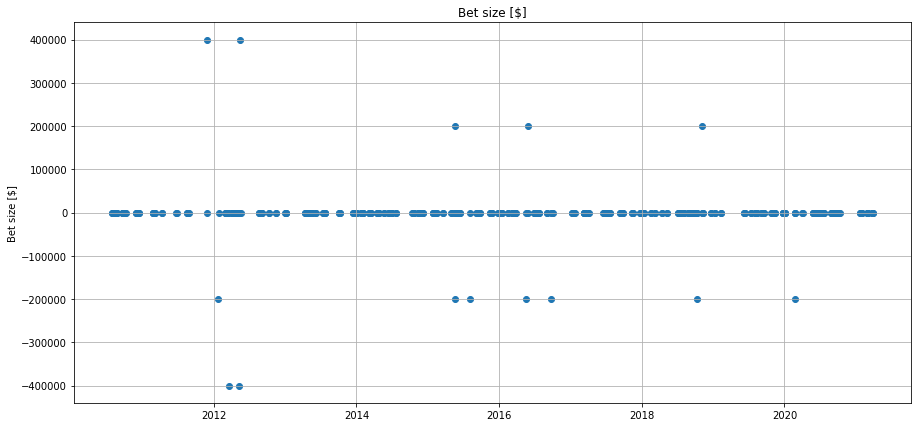

In [ ]:
BUDGET=1000000

fig, ax = plt.subplots(figsize=(15,7))
plt.scatter(x=bets.index, y=(bets * BUDGET))
plt.title('Bet size [$]')
plt.ylabel('Bet size [$]')
plt.grid()
plt.show()

# Feature Importance

In [ ]:
# SNIPPET 8.2 MDI (MEAN DECREASE IMPURITY) FEATURE IMPORTANCE
def featImpMDI(fit, featNames):
  # feat importance based on IS mean impurity reduction
  df0 = {i:tree.feature_importances_ for i, tree in enumerate(fit.estimators_)}
  df0 = pd.DataFrame.from_dict(df0,orient='index')
  df0.columns = featNames
  df0 = df0.replace(0,np.nan) # because max_features=1
  imp = pd.concat({'mean':df0.mean(),
                   'std':df0.std()*df0.shape[0]**-.5},
                  axis=1)
  imp/=imp['mean'].sum()

  return imp

# Snippet 8.3 implements MDA feature importance with sample weights, with
# purged k-fold CV, and with scoring by negative log-loss or accuracy. 
# It measures MDA importance as a function of the improvement (from permutating
# to not permutating the feature), relative to the maximum possible score 
# (negative log-loss of 0, or accuracy of 1). Note that, in some cases, the 
# improvement may be negative, meaning that the feature is actually detrimental 
# to the forecasting power of the ML algorithm.

# SNIPPET 8.3 MDA FEATURE IMPORTANCE
def featImpMDA(clf,X,y,cv,sample_weight,t1,pctEmbargo,scoring='neg_log_loss'):
  # feat importance based on OOS score reduction
  if scoring not in ['neg_log_loss','accuracy']:
    raise Exception('wrong scoring method.')
  from sklearn.metrics import log_loss, accuracy_score

  cvGen = PurgedKFold(n_splits=cv,t1=t1,pctEmbargo=pctEmbargo) # purged cv
  scr0,scr1 = pd.Series(),pd.DataFrame(columns=X.columns)
  for i,(train,test) in enumerate(cvGen.split(X=X)):
    X0,y0,w0 = X.iloc[train,:],y.iloc[train],sample_weight.iloc[train]
    X1,y1,w1 = X.iloc[test,:],y.iloc[test],sample_weight.iloc[test]
    fit = clf.fit(X=X0,y=y0,sample_weight=w0.values)
    if scoring=='neg_log_loss':
      prob = fit.predict_proba(X1)
      scr0.loc[i]=-log_loss(y1,prob,sample_weight=w1.values,labels=clf.classes_)
    else:
      pred = fit.predict(X1)
      scr0.loc[i] = accuracy_score(y1,pred,sample_weight=w1.values)
    for j in X.columns:
      X1_=X1.copy(deep=True)
      np.random.shuffle(X1_[j].values) # permutation of a single column
      if scoring=='neg_log_loss':
        prob = fit.predict_proba(X1_)
        scr1.loc[i,j]=-log_loss(y1,prob,sample_weight=w1.values,labels=clf.classes_)
      else:
        pred = fit.predict(X1_)
        scr1.loc[i,j] = accuracy_score(y1,pred,sample_weight=w1.values)
  imp = (-scr1).add(scr0,axis=0)
  if scoring=='neg_log_loss':imp=imp/-scr1
  else: imp = imp/(1.-scr1)
  imp=pd.concat({'mean':imp.mean(),
                 'std':imp.std()*imp.shape[0]**-.5},
                axis=1)

  return imp,scr0.mean()

In [ ]:
featImpMDI(best_randomsearch, ['trgt', 'side', 'w','S2F_Dif','yield_Dif','AdrActCnt'])

,mean,std
trgt,0.176976,0.007815
side,0.087818,0.002978
w,0.209622,0.008164
S2F_Dif,0.169024,0.006571
yield_Dif,0.193675,0.009470
AdrActCnt,0.162884,0.007150


# Backtesting

In [ ]:
import numpy as np
from random import gauss
from itertools import product

# Snippet 13.1 provides an implementation in Python of the experiments conducted in
#this chapter. Function main produces a Cartesian product of parameters (E0[Pi,Ti], 𝜏),
#which characterize the stochastic process from equation (13.5).

# Modificamos la función, para permitirnos especificar los parámetros al utilizarla
def main_btc(forecast=[10,5,0,-5,-10], speed=[5,10,25,50,100], rPT=np.linspace(0,10,21), rSLm=np.linspace(0,10,21),nIter=1e5,maxHP=100, seed=0):
 count=0
 for prod_ in product(forecast,speed):
  count+=1
  coeffs={'forecast':prod_[0],'hl':prod_[1],'sigma':1}
  output=batch(coeffs,nIter,maxHP,rPT,rSLm, seed)
 return output
   
# La función batch computa el ratio Sharpe asociado a varias trading rules.
# El valor seed tiene que ser la media de largo plazo de la serie de bets (valor de equilibrio de la estrategia)
# coeffs['forecast'] es la serie de bets para cada observación
# coeffs['hl'] refleja la vida media de un bet. Mientras más crece, el proceso de convergencia se acerca más a un random walk.
# Una condición necesaria y suficiente para la estacionariedad de los bets es que 𝜑 ∈ (-1,1), donde 𝜑 = 2^−1∕t (A mayor t, mayor 𝜑). 
def batch(coeffs,nIter=1e5,maxHP=100,rPT=np.linspace(.5,10,20), rSLm=np.linspace(.5,10,20),seed=0):
  phi,output1=2**(-1./coeffs['hl']),[]
  # Matriz de pares profit-taking y stop-loss ('rPT' y 'rSLm')
  for comb_ in product(rPT,rSLm):
    output2=[]
    # Generación de un cantidad de escenarios 'nIter', donde la posición no puede mantenerse más de una cantidad de períodos 'maxHP'
    for iter_ in range(int(nIter)):
      p,hp,count=seed,0,0
      while True:
        p=(1-phi)*coeffs['forecast']+phi*p+coeffs['sigma']*gauss(0,1)
        cP=p-seed;hp+=1
        if cP>comb_[0] or cP<-comb_[1] or hp>maxHP:
          output2.append(cP)
          break
      mean,std=np.mean(output2),np.std(output2)
      print (comb_[0],comb_[1],mean,std,mean/std)
      output1.append((comb_[0],comb_[1],mean,std,mean/std))
  return output1
  # mean referencia la media de largo plazo de la serie de bets
  # std referencia la volatilidad instantánea de la serie de bets


Ponemos los siguientes parámetros:

*   Velocidad de convergencia: Lista [5,10,25,50,100]
*   Cantidad máxima de períodos donde puedo mantener una misma posición: 2500
*   Retorno de equilibrio de largo plazo: 0
*   Cantidad de iteraciones: 1000

In [ ]:
# Filtramos la serie de bets, de manera de obtener la serie de oportunidades.
bets[bets!=0]*1000000

2011-11-29    400000.0
2012-01-25   -200000.0
2012-03-20   -400000.0
2012-05-09   -400000.0
2012-05-16    400000.0
2015-05-18   -200000.0
2015-05-22    200000.0
2015-08-05   -200000.0
2016-05-19   -200000.0
2016-05-27    200000.0
2016-09-21   -200000.0
2018-10-11   -200000.0
2018-11-06    200000.0
2020-02-24   -200000.0
dtype: float64

In [ ]:
otc = main_btc(forecast=bets[bets!=0]*1000000, speed=[5,10,25,50,100], nIter=100, maxHP=2500, seed=0)

Streaming output truncated to the last 5000 lines.
6.5 9.5 -2753.362597814329 0.8917628726546101 -3087.550157384426
6.5 10.0 -2753.592832846054 1.0711803134813331 -2570.6156080267056
7.0 0.0 -2753.521155721366 1.001166958830328 -2750.311655249119
7.0 0.5 -2753.3566507707087 0.9668790226069326 -2847.6744105451926
7.0 1.0 -2753.2954654137925 0.8366009990046495 -3291.0496983502776
7.0 1.5 -2753.426049391804 1.0467037840316502 -2630.568544222007
7.0 2.0 -2753.4893779202503 1.0678153137702453 -2578.619488231745
7.0 2.5 -2753.567481732906 0.9919390460652262 -2775.9442403801104
7.0 3.0 -2753.452244893756 0.9054743105436098 -3040.894935208814
7.0 3.5 -2753.222289420688 1.071439500844866 -2569.647924357539
7.0 4.0 -2753.344135627142 0.9969514527110482 -2761.763502264697
7.0 4.5 -2753.54455402359 0.902979785730015 -3049.397780037217
7.0 5.0 -2753.3269488805004 0.9457076759995227 -2911.393254760777
7.0 5.5 -2753.484218203982 1.009531547494402 -2727.487045885756
7.0 6.0 -2753.4474150414258 1.02882

In [ ]:
max([sublist[4] for sublist in otc])

-1154.511318346226

# Strategy Risk

# PORTFOLIO RISK: Value at Risk (VaR) y Conditional Value at Risk (CVaR)

In [ ]:
returns = pd.Series(df.PriceUSD.pct_change(), name="Returns")
returns.dropna(inplace=True)

In [ ]:
def historicalVaR(returns, alpha=5, interpolation="lower"):
  """
  Lee retornos desde un pd.DataFrame o pd.Series.
  Devuelve el percentil de la distribución histórica al nivel de confianza parametrizado. Entre [0:100]
  Opciones de interpolación: {‘linear’, ‘lower’, ‘higher’, ‘midpoint’, ‘nearest’}
  """
  if isinstance(returns, pd.Series):
    return np.percentile(returns, alpha, interpolation=interpolation)

  # Dejamos configurada una función de pandas que evalúa para cada columna nuestra User Defined Function historicalVaR
  elif isinstance(returns, pd.DataFrame):
    # A la función que usaremos además deben pasarse los parámetros, en este caso alpha:
    return returns.aggregate(historicalVaR, alpha=5)

  else:
    raise TypeError("returns needs to be a pd.DataFrame or pd.Series")

def historicalCVaR(returns, alpha=5, interpolation="lower"):
  """
  Lee retornos desde un pd.DataFrame o pd.Series.
  Devuelve el CVaR al nivel de confianza parametrizado. Entre [0:100]
  """
  if isinstance(returns, pd.Series):
    belowVaR = returns <= historicalVaR(returns, alpha=alpha) # Creamos un vector booleano
    return returns[belowVaR].mean() # aplicamos al vector booleano la operación de promedio

  # Dejamos configurada una función de pandas que evalúa para cada columna nuestra User Defined Function historicalVaR
  elif isinstance(returns, pd.DataFrame):
    # A la función que usaremos además deben pasarse los parámetros, en este caso alpha:
    return returns.aggregate(historicalCVaR, alpha=5)

  else:
    raise TypeError("returns needs to be a pd.DataFrame or pd.Series")

In [ ]:
VaR_BTC = historicalVaR(returns, 0.1, "lower")
VaR_BTC
CVaR_BTC = historicalCVaR(returns, 0.1, "lower")
CVaR_BTC

-0.4045054777623179